# Evaluating DeBERTaV3 with the Nonparametric Analysis
---
*A nonparametric analysis of hyperparameter search for fine-tuning DeBERTa and DeBERTaV3*

For more background, see the notebook [**Nonparametric Analysis**](../theory/nonparametric-analysis.ipynb) or our paper: [**Show Your Work with Confidence: Confidence Bands for Tuning Curves**](https://arxiv.org/abs/2311.09480).

In [1]:
# imports

import json
import warnings

from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

from opda import nonparametric, utils
from experiments import visualization


# constants

evaluations = {
    'matched': {
        'name': 'MultiNLI-m'
    },
    'mismatched': {
        'name': 'MultiNLI-mm'
    },
}

models = {
    'deberta-base': {
        'name': 'DeBERTa',
        'style': {'linestyle': '-', 'color': '#FFB000'},
    },
    'deberta-v3-base': {
        'name': 'DeBERTaV3',
        'style': {'linestyle': '--', 'color': '#648FFF'},
    },
}

bands = {
    'dkw': {
        'name': 'DKW',
        'method': 'dkw',
        'style': {'linestyle': '-.', 'color': '#FE6100'},
    },
    'ks': {
        'name': 'KS', 
        'method': 'ks', 
        'style': {'linestyle': '-', 'color': '#FFB000'},
    },
    'ld_equal_tailed': {
        'name': 'LD (equal-tailed)',
        'method': 'ld_equal_tailed',
        'style': {'linestyle': ':', 'color': '#785EF0'},
    },
    'ld_highest_density': {
        'name': 'LD (highest density)',
        'method': 'ld_highest_density',
        'style': {'linestyle': '--', 'color': '#648FFF'},
    },
}

confidences = {
    0.01: {'style': {'marker': 'D', 'color': 'tab:gray'  }},
    0.05: {'style': {'marker': 'o', 'color': 'tab:blue'  }},
    0.10: {'style': {'marker': 'P', 'color': 'tab:orange'}},
    0.25: {'style': {'marker': 'X', 'color': 'tab:green' }},
    0.50: {'style': {'marker': '*', 'color': 'tab:red'   }},
    0.75: {'style': {'marker': 's', 'color': 'tab:purple'}},
    0.90: {'style': {'marker': 'v', 'color': 'tab:brown' }},
    0.95: {'style': {'marker': '^', 'color': 'tab:pink'  }},
    0.99: {'style': {'marker': 'p', 'color': 'tab:cyan'  }},
}


# Configure environment.

np.random.seed(0)

warnings.filterwarnings('ignore')


# Configure Matplotlib.

plt.style.use('experiments.default')

## The DeBERTa Model Family

One approach to natural language processing takes a neural network pretrained with raw text and then fine-tunes it on labeled data. [DeBERTa](https://github.com/microsoft/DeBERTa) offers one such pretrained model, with two major versions: *DeBERTa* [(He et al., 2021(a))](https://arxiv.org/abs/2006.03654) and *DeBERTaV3* [(He et al., 2021(b))](https://arxiv.org/abs/2111.09543).

Despite sharing their name, DeBERTa and DeBERTaV3 have significant differences as models. For example, DeBERTa is trained with a generative masked-language modeling objective [(Devlin et al., 2018)](https://arxiv.org/abs/1810.04805), while DeBERTaV3 uses the discriminative ELECTRA pretraining [(Clark et al., 2020)](https://arxiv.org/abs/2003.10555).

Both models have a number of hyperparameters to set when fine-tuning them. We can investigate these models individually and compare them to each other using optimal design analysis (OPDA).

## Experimental Design

In our case study, we compare fine-tuning two pretrained models, DeBERTa and DeBERTaV3, for natural language inference (NLI) on the [MultiNLI dataset](https://cims.nyu.edu/~sbowman/multinli/) [(Adina et al., 2018)](https://arxiv.org/abs/1704.05426).

When assessing models with OPDA, one must first define the hyperparameter search distribution and then sample and evaluate hyperparameters from it. Since DeBERTa and DeBERTaV3 share the same hyperparameters for fine-tuning, we used the same search distribution for both:

$$
\begin{align*}
  \mathtt{batch}\_\mathtt{size} &\sim \operatorname{DiscreteUniform}(16, 64) \\
  \mathtt{num}\_\mathtt{epochs} &\sim \operatorname{DiscreteUniform}( 1,  4) \\
  \mathtt{warmup}\_\mathtt{proportion} &\sim \operatorname{Uniform}(0, 0.6) \\
  \mathtt{learning}\_\mathtt{rate} &\sim \operatorname{LogUniform}(10^{-6}, 10^{-3}) \\
  \mathtt{dropout} &\sim \operatorname{Uniform}(0, 0.3) \\
\end{align*}
$$

where $\mathtt{warmup}\_\mathtt{proportion}$ is the number of warmup steps as a proportion of the first epoch. 

We fine-tuned both DeBERTa and DeBERTaV3 on MultiNLI using 1,024 hyperparameter settings sampled from this search distribution. MultiNLI has two validation sets: matched (same domains as training) and mismatched (different domains from training). Each fine-tuned model was evaluated on both. Thus, for each model and validation set we have 1,024 accuracy numbers&mdash;one for each sampled set of hyperparameters.

In [2]:
# load the data
model_to_evaluation_to_ys = {}
for model_ in models:
    for evaluation_ in evaluations:
        ys = []
        with open(f'../../data/deberta/{model_}.results.jsonl') as f_in:
            for ln in f_in:
                ex = json.loads(ln)
                ys.append(max(
                    score
                    for _, score in ex['learning_curves'][evaluation_]
                ))
        if model_ not in model_to_evaluation_to_ys:
            model_to_evaluation_to_ys[model_] = {}
        model_to_evaluation_to_ys[model_][evaluation_] = np.array(ys)
    
total_samples = 1_024
for model_ in models:
    for evaluation_ in evaluations:
        if len(model_to_evaluation_to_ys[model_][evaluation_]) != total_samples:
            raise RuntimeError(
                'The experiment data does not contain the correct'
                ' number of examples.'
            )

In [3]:
# experimental settings

evaluation = 'matched'
model = 'deberta-v3-base'
band = 'ld_highest_density'

sample_sizes = [6, 20, 34, 48]
n = sample_sizes[-1]  # Later analyses assume n == sample_sizes[-1]
ns = np.arange(1, n+1)
ns_grid = np.linspace(1, n, num=10_000)

y_min = 0.
y_max = 1.
grid = np.linspace(y_min, y_max, num=100)

confidence = 0.80

bws = [1.0e-1, 7.5e-2, 5e-2, 2.5e-2]
bw = 5e-2

n_trials = 1_024

cdf_confidence = 0.95
coverage_confidence = 0.99

## Tutorial: Comparing DeBERTa to DeBERTaV3

Suppose we wanted to compare fine-tuning DeBERTa and DeBERTaV3 for NLI using MultiNLI [(Adina et al., 2018)](https://arxiv.org/abs/1704.05426). OPDA recommends that we identify the hyperparameters, define a search distribution, and then analyze the tuning curves associated with this search distribution. Assume we used the search distribution defined above:

$$
\begin{align*}
  \mathtt{batch}\_\mathtt{size} &\sim \operatorname{DiscreteUniform}(16, 64) \\
  \mathtt{num}\_\mathtt{epochs} &\sim \operatorname{DiscreteUniform}( 1,  4) \\
  \mathtt{warmup}\_\mathtt{proportion} &\sim \operatorname{Uniform}(0, 0.6) \\
  \mathtt{learning}\_\mathtt{rate} &\sim \operatorname{LogUniform}(10^{-6}, 10^{-3}) \\
  \mathtt{dropout} &\sim \operatorname{Uniform}(0, 0.3) \\
\end{align*}
$$

where $\mathtt{warmup}\_\mathtt{proportion}$ is the number of warmup steps as a proportion of the first epoch. 

If our aim is to evaluate DeBERTaV3, then one rule of thumb for picking the number of search iterations is to determine how many iterations we expect model users to perform and then multiply that by at least 6.25 (if we plan to use 80% confidence bands). So, if a typical model user will perform 6-8 search iterations, we'll use at least 37.5 to 50 to construct the tuning curve. For this analysis, we'll use 48.

Since the nonparametric bands from OPDA hold simultaneously, they provide quite a strong guarantee, so we'll use an 80% confidence level for constructing our bands.

### Evaluating a Single Model

To evaluate a single model, we construct the tuning curve with confidence bands. Potential users can then read the cost-benefit trade off from these plots and determine whether the model achieves sufficient performance for their application and within their computational budget. For DeBERtaV3 on MultiNLI, the tuning curves look as follows:

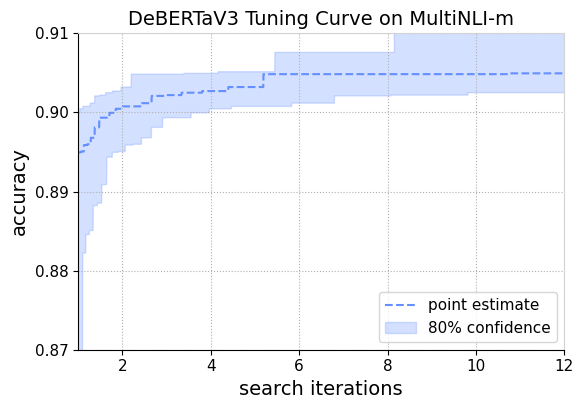

In [4]:
# Subsample the data to obtain a sample of size n.
ys = np.random.choice(
    model_to_evaluation_to_ys[model][evaluation],
    size=n,
    replace=False,
)

# Construct the confidence bands.
lower_cdf, point_cdf, upper_cdf =\
    nonparametric.EmpiricalDistribution.confidence_bands(
        ys,
        confidence=confidence,
        a=y_min,
        b=y_max,
        method=band,
    )

# Plot the confidence bands.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.25))

ax.plot(
    ns_grid, 
    point_cdf.quantile_tuning_curve(ns_grid),
    label='point estimate',
    **models[model]['style'],
)
ax.fill_between(
    ns_grid,
    upper_cdf.quantile_tuning_curve(ns_grid),
    lower_cdf.quantile_tuning_curve(ns_grid),
    alpha=0.275,
    label=f'{confidence * 100:.0f}% confidence',
    color=models[model]['style']['color'],
)

# Format the plot.
ax.set_xlim(1, n // 4)
ax.set_ylim(0.87, 0.91)
ax.set_yticks(np.linspace(0.87, 0.91, num=5))
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.legend(loc='lower right')
ax.set_xlabel('search iterations')
ax.set_ylabel('accuracy')
ax.set_title(
    f'{models[model]["name"]} Tuning Curve'
    f' on {evaluations[evaluation]["name"]}'
)

fig.tight_layout()

plt.show()

Thus, we see that with 48 search iterations, we can bound the tuning curve fairly tightly up to about 8 search iterations. Below, we visualize what the tuning curve bounds look like for various sample sizes and both the matched and mismatched MultiNLI test sets:

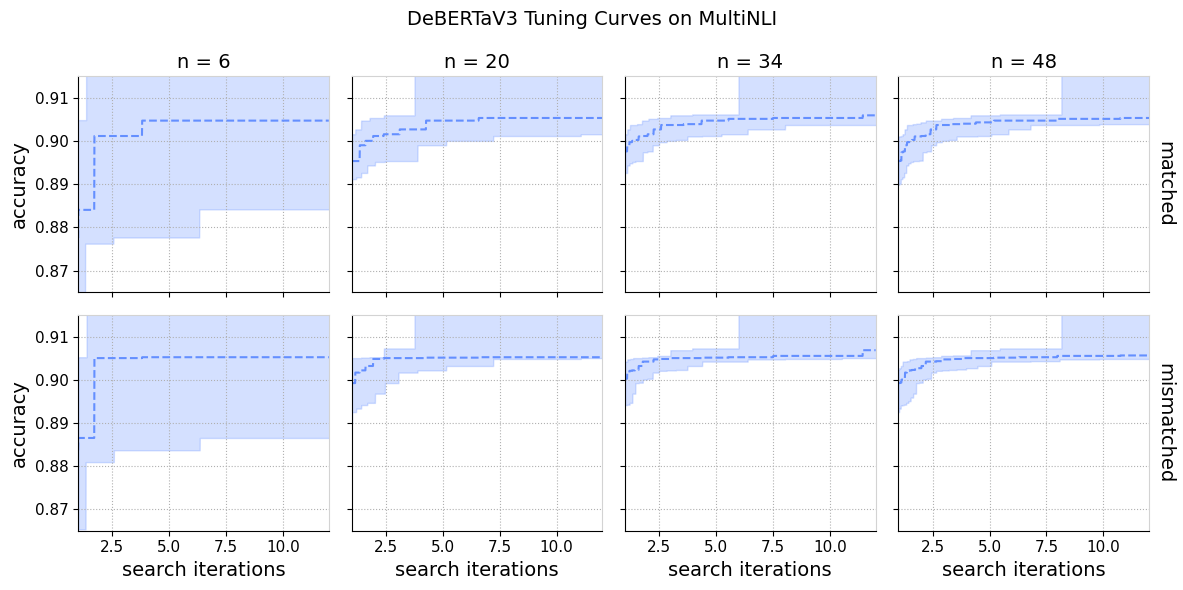

In [5]:
# Choose indices to subsample the data and obtain a sample of size
# sample_size_.
idxs = np.random.choice(total_samples, size=n, replace=False)

fig, axes = plt.subplots(
    nrows=2,
    ncols=len(sample_sizes),
    sharex=True,
    sharey='row',
    figsize=(12, 6),
)
for j, sample_size_ in enumerate(sample_sizes):
    for i, evaluation_ in enumerate(evaluations):
        ys = model_to_evaluation_to_ys[model][evaluation_][
            idxs[:sample_size_]
        ]

        # Construct the confidence bands.
        lower_cdf, point_cdf, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band,
            )

        # Plot the confidence bands.
        axes[i, j].plot(
            ns_grid, 
            point_cdf.quantile_tuning_curve(ns_grid),
            **models[model]['style'],
        )
        axes[i, j].fill_between(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            lower_cdf.quantile_tuning_curve(ns_grid),
            alpha=0.275,
            color=models[model]['style']['color'],
        )

# Format the plot.
for j, sample_size_ in enumerate(sample_sizes):
    axes[1, j].set_xlabel('search iterations')
    axes[0, j].set_title(f'n = {sample_size_}')
    
for i, evaluation_ in enumerate(evaluations):
    axes[i, 0].set_ylabel('accuracy')
    axes[i, -1].yaxis.set_label_position('right')
    axes[i, -1].set_ylabel(evaluation_, labelpad=18, rotation=270)
        
for i in range(len(evaluations)):
    for j in range(len(sample_sizes)):
        axes[i, j].set_xlim(1, n // 4)
        axes[i, j].set_ylim(0.865, 0.915)
        axes[i, j].spines['right'].set_color('lightgrey')
        axes[i, j].spines['top'].set_color('lightgrey')

fig.suptitle(
    f'{models[model]["name"]} Tuning Curves on MultiNLI'
)

fig.tight_layout()

plt.show()

We see the main effect of increasing sample size is to shift over the point at which the upper confidence band jumps to the upper bound on performance. Increasing the sample size does tend to narrow the band as well; however, the effect is not very noticeable on DeBERTaV3.

### Comparing Two Models

Beyond evaluating a single model, we may also want to compare two models. To accomplish this task, we can plot their tuning curves with confidence bands side-by-side:

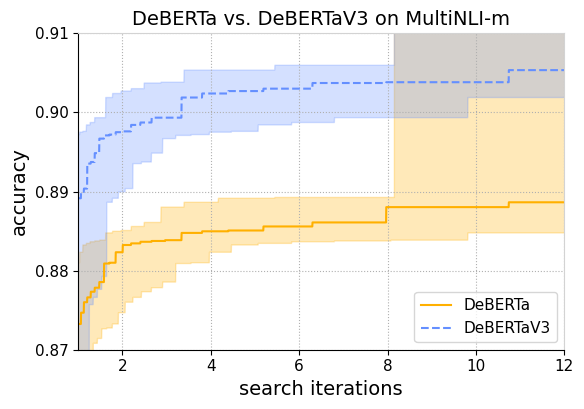

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.25))
for model_ in models:
    # Subsample the data to obtain a sample of size n.
    ys = np.random.choice(
        model_to_evaluation_to_ys[model_][evaluation],
        size=n,
        replace=False,
    )

    # Construct the confidence bands.
    lower_cdf, point_cdf, upper_cdf =\
        nonparametric.EmpiricalDistribution.confidence_bands(
            ys,
            confidence=confidence,
            a=y_min,
            b=y_max,
            method=band,
        )

    # Plot the confidence bands.
    ax.plot(
        ns_grid, 
        point_cdf.quantile_tuning_curve(ns_grid),
        label=models[model_]['name'],
        **models[model_]['style'],
    )
    ax.fill_between(
        ns_grid,
        upper_cdf.quantile_tuning_curve(ns_grid),
        lower_cdf.quantile_tuning_curve(ns_grid),
        alpha=0.275,
        color=models[model_]['style']['color'],
    )

# Format the plot.
ax.set_xlim(1, n // 4)
ax.set_ylim(0.87, 0.91)
ax.set_yticks(np.linspace(0.87, 0.91, num=5))
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.legend(loc='lower right')
ax.set_xlabel('search iterations')
ax.set_ylabel('accuracy')
ax.set_title(
    f'DeBERTa vs. DeBERTaV3 on {evaluations[evaluation]["name"]}'
)

fig.tight_layout()

plt.show()

In general, it's tempting to require that there's no overlap between the confidence bands before concluding that one model is better than the other; however, this criterion is too conservative. Inspired by [Minka (2002)](https://tminka.github.io/papers/minka-errorbars.pdf), one could use the following guidelines: the evidence for an improvement is *weak* if one point estimate is excluded by the other's confidence bands, *fair* if each point estimate is excluded by the other's confidence bands, and *strong* if the confidence bands have no overlap, over a nontrivial portion of the tuning curve.

We see clear separation between DeBERTa and DeBERTaV3's tuning curves. Thus, we can confidently conclude that DeBERTaV3 outperforms DeBERTa for all hyperparameter tuning budgets (or at least up to a budget of 8 search iterations).

Again, we can also explore what our plots would've looked like for various other sample sizes:

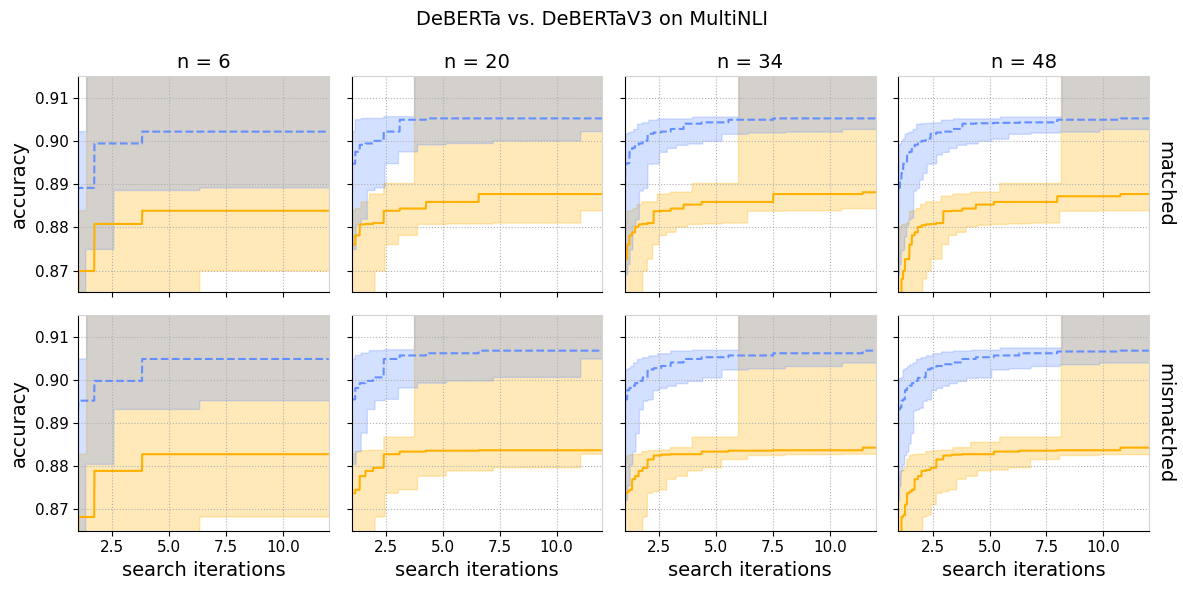

In [7]:
# Choose indices to subsample the data and obtain a sample of size 
# sample_size_.
idxs = np.random.choice(total_samples, size=n, replace=False)

fig, axes = plt.subplots(
    nrows=2,
    ncols=len(sample_sizes),
    sharex=True,
    sharey='row',
    figsize=(12, 6),
)
for j, sample_size_ in enumerate(sample_sizes):
    for i, evaluation_ in enumerate(evaluations):
        for model_ in models:
            ys = model_to_evaluation_to_ys[model_][evaluation_][
                idxs[:sample_size_]
            ]

            # Construct the confidence bands.
            lower_cdf, point_cdf, upper_cdf =\
                nonparametric.EmpiricalDistribution.confidence_bands(
                    ys,
                    confidence=confidence,
                    a=y_min,
                    b=y_max,
                    method=band,
                )

            # Plot the confidence bands.
            axes[i, j].plot(
                ns_grid, 
                point_cdf.quantile_tuning_curve(ns_grid),
                label=models[model_]['name'],
                **models[model_]['style'],
            )
            axes[i, j].fill_between(
                ns_grid,
                upper_cdf.quantile_tuning_curve(ns_grid),
                lower_cdf.quantile_tuning_curve(ns_grid),
                alpha=0.275,
                color=models[model_]['style']['color'],
            )

# Format the plot.
for j, sample_size_ in enumerate(sample_sizes):
    axes[1, j].set_xlabel('search iterations')
    axes[0, j].set_title(f'n = {sample_size_}')
    
for i, evaluation_ in enumerate(evaluations):
    axes[i, 0].set_ylabel('accuracy')
    axes[i, -1].yaxis.set_label_position('right')
    axes[i, -1].set_ylabel(evaluation_, labelpad=18, rotation=270)
        
for i in range(len(evaluations)):
    for j in range(len(sample_sizes)):
        axes[i, j].set_xlim(1, n // 4)
        axes[i, j].set_ylim(0.865, 0.915)
        axes[i, j].spines['right'].set_color('lightgrey')
        axes[i, j].spines['top'].set_color('lightgrey')

fig.suptitle('DeBERTa vs. DeBERTaV3 on MultiNLI')

fig.tight_layout()

plt.show()

Similarly to before, our conclusion would've remained largely the same regardless of sample size. The main difference is at what number of search iterations our confidence bands become trivial, and thus for how far we can confidently claim DeBERTaV3 outperforms DeBERTa.

## Choosing the Sample Size

One important decision in our previous experiment was the total number of search iterations. If the experiment had too few iterations then it'd fail to provide a useful conclusion. On the other hand, running too many iterations would waste resources. What's more, if we collected iterations until the confidence bands give a useful conclusion, then we'd lose our statistical guarantees due to the optional stopping problem [(Yu et al., 2014)](https://doi.org/10.3758/s13423-013-0495-z). Thus, we'd like to know, a priori, what sample size is necessary. In statistics, this exercise is usually called a *power analysis*. While we don't develop a formal power analysis here, we'll explore a useful empirical rule of thumb.

### How Does Sample Size Affect the Confidence Bands?

Let's build some intuition for how the confidence bands change as we increase the sample size. First, we'll plot the confidence bands for various sample sizes, and second we'll plot where the confidence band becomes trivial (the upper bound on the support) against the total sample size.

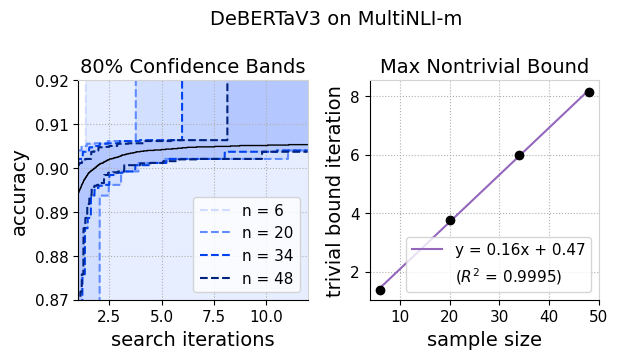

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6.25, 3.65))

# Plot the confidence bands for various sample sizes.
ys = np.random.choice(
    model_to_evaluation_to_ys[model][evaluation],
    size=n,
    replace=False,
)
for sample_size_ in sample_sizes:
    # Construct the confidence bands.
    lower_cdf, _, upper_cdf =\
        nonparametric.EmpiricalDistribution.confidence_bands(
            ys[:sample_size_],
            confidence=confidence,
            a=y_min,
            b=y_max,
            method=band,
        )

    # Plot the confidence bands.
    color = visualization.color_with_lightness(
        c=bands[band]['style']['color'],
        lightness=0.75 * (1 - sample_size_ / n) + 0.25,
    )
    
    axes[0].plot(
        ns_grid, 
        lower_cdf.quantile_tuning_curve(ns_grid),
        label=f'n = {sample_size_}',
        **{**bands[band]['style'], 'color': color},
    )
    axes[0].plot(
        ns_grid,
        upper_cdf.quantile_tuning_curve(ns_grid),
        **{**bands[band]['style'], 'color': color},
    )
    axes[0].fill_between(
        ns_grid,
        upper_cdf.quantile_tuning_curve(ns_grid),
        lower_cdf.quantile_tuning_curve(ns_grid),
        alpha=0.15,
        color=bands[band]['style']['color'],
    )

# Plot our best estimate of the ground truth.
point_cdf = nonparametric.EmpiricalDistribution(
    model_to_evaluation_to_ys[model][evaluation],
    a=y_min,
    b=y_max,
)

axes[0].plot(
    ns_grid, 
    point_cdf.quantile_tuning_curve(ns_grid),
    linewidth=1,
    linestyle='-',
    color='k',
)

# Format the plot.
axes[0].set_xlim(1, n // 4)
axes[0].set_ylim(0.87, 0.92)
axes[0].spines['right'].set_color('lightgrey')
axes[0].spines['top'].set_color('lightgrey')
axes[0].legend(loc='lower right')
axes[0].set_xlabel('search iterations')
axes[0].set_ylabel('accuracy')
axes[0].set_title(
    f'{confidence * 100:.0f}% Confidence Bands'
)

# Plot the trivial bound iteration vs. the sample size.
trivial_bound_iterations = []
for sample_size_ in sample_sizes:
    ys = np.random.choice(
        model_to_evaluation_to_ys[model][evaluation],
        size=sample_size_,
        replace=False,
    )

    lower_cdf, _, _ =\
        nonparametric.EmpiricalDistribution.confidence_bands(
            ys,
            confidence=confidence,
            a=y_min,
            b=y_max,
            method=band,
        )

    trivial_bound_iterations.append(
        ns_grid[np.argmax(lower_cdf.quantile_tuning_curve(ns_grid))]
    )

# Fit a linear regression to the sample size/trivial bound iteration data.
regression = stats.linregress(sample_sizes, trivial_bound_iterations)

axes[1].scatter(
    sample_sizes,
    trivial_bound_iterations,
    color='k',
    zorder=10,
)
axes[1].plot(
    sample_sizes,
    [
        regression.slope * sample_size_ + regression.intercept
        for sample_size_ in sample_sizes
    ],
    color='tab:purple',
    label=f'y = {regression.slope:.2f}x + {regression.intercept:.2f}',
)
axes[1].plot(
    [], 
    [],
    ' ',
    label=rf'($R^2$ = {regression.rvalue**2:.4f})',
)

# Format the plot.
axes[1].spines['right'].set_color('lightgrey')
axes[1].spines['top'].set_color('lightgrey')
axes[1].legend(loc='lower right')
axes[1].set_xlabel('sample size')
axes[1].set_ylabel('trivial bound iteration')
axes[1].set_title('Max Nontrivial Bound')

fig.suptitle(
    f'{models[model]["name"]} on {evaluations[evaluation]["name"]}',
    x=0.55,
)

fig.tight_layout()

plt.show()

On the right, we see where the upper confidence band becomes trivial (i.e., jumps to the upper bound) seems evenly spaced as we linearly increase the sample size. That observation suggests that there's a linear relationship between the sample size and where the upper bound becomes trivial. The plot on the right confirms this hypothesis, revealing a nearly perfect linear relationship with 99.95% of the variance explained.

### How Does the Trivial Bound Iteration Depend on the Confidence?

We've seen that for 80% confidence, there's a strong linear relationship between the sample size and the trivial bound search iteration. In general, this relationship depends on the confidence level. Let's plot this relationship for different confidence levels as well as different models:

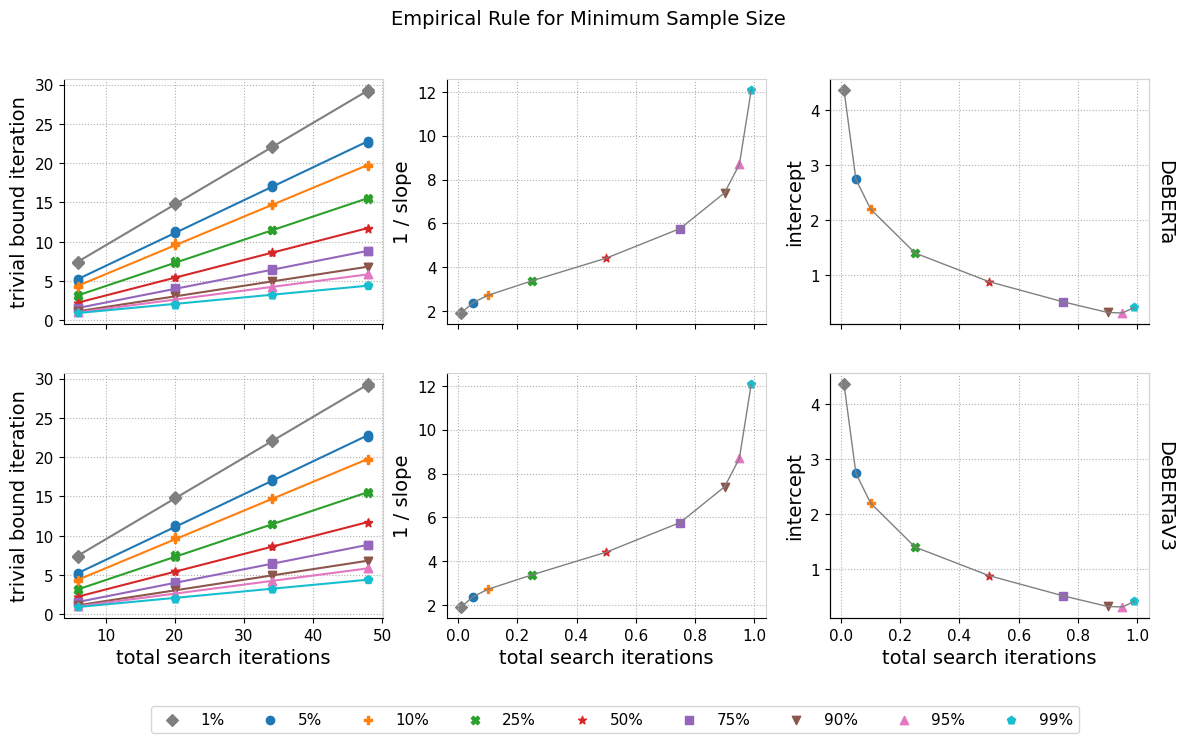

In [9]:
# Compute the linear relationships between the total number of search
# iterations and the trivial bound iteration.
model_to_confidence_to_results = {model_: {} for model_ in models}
for model_ in models:
    for confidence_ in confidences:
        trivial_bound_locations = []
        for sample_size_ in sample_sizes:
            ys = np.random.choice(
                model_to_evaluation_to_ys[model][evaluation],
                size=sample_size_,
                replace=False,
            )

            lower_cdf, _, _ =\
                nonparametric.EmpiricalDistribution.confidence_bands(
                    ys,
                    confidence=confidence_,
                    a=y_min,
                    b=y_max,
                    method=band,
                )

            trivial_bound_locations.append(
                ns_grid[np.argmax(lower_cdf.quantile_tuning_curve(ns_grid))]
            )

        regression = stats.linregress(sample_sizes, trivial_bound_locations)
        
        model_to_confidence_to_results[model_][confidence_] = (
            regression, trivial_bound_locations,
        )

# Plot the linear relationships and how their parameters change.
fig, axes = plt.subplots(
    nrows=len(models),
    ncols=3,
    sharex='col',
    sharey='col',
    figsize=(14, 7),
)
for i, model_ in enumerate(models):
    for confidence_ in confidences:
        regression, trivial_bound_locations =\
            model_to_confidence_to_results[model_][confidence_]

        # Plot the linear relationships.
        axes[i, 0].scatter(
            sample_sizes,
            trivial_bound_locations,
            label=f'{confidence_ * 100:.0f}%',
            **confidences[confidence_]['style'],
        )
        axes[i, 0].plot(
            sample_sizes,
            [
                regression.slope * sample_size_ + regression.intercept
                for sample_size_ in sample_sizes
            ],
            **confidences[confidence_]['style'],
        )

        # NOTE: In order to apply separate styles to each point, separately plot
        # each point for the 1/slope and intercept vs. total search iterations
        # relationships.
        
        # Plot 1/slope vs. total search iterations.
        axes[i, 1].scatter(
            [confidence_],
            [1/regression.slope],
            **confidences[confidence_]['style'],
        )
        # Plot intercept vs. total search iterations.
        axes[i, 2].scatter(
            [confidence_],
            [regression.intercept],
            **confidences[confidence_]['style'],
        )

    # Add a line connecting the points in the 1/slope vs. total search
    # iterations plot.
    axes[i, 1].plot(
        *zip(*[
            (confidence_, 1/regression.slope)
            for confidence_, (regression, _)
            in model_to_confidence_to_results[model_].items()
        ]),
        color='grey',
        linewidth=1,
    )
    # Add a line connecting the points in the intercept vs. total search
    # iterations plot.
    axes[i, 2].plot(
        *zip(*[
            (confidence_, regression.intercept)
            for confidence_, (regression, _)
            in model_to_confidence_to_results[model_].items()
        ]),
        color='grey',
        linewidth=1,
    )

# Format the plot.
for i, model_ in enumerate(models):
    axes[i, 0].set_ylabel('trivial bound iteration')
    axes[i, 1].set_ylabel('1 / slope')
    axes[i, 2].set_ylabel('intercept')
    
    yaxis2 = axes[i, -1].twinx()
    yaxis2.set_yticks([])
    yaxis2.spines['right'].set_color('lightgrey')
    yaxis2.spines['top'].set_color('lightgrey')
    yaxis2.set_ylabel(models[model_]['name'], labelpad=18, rotation=270)
    
for j in range(3):
    axes[len(models)-1, j].set_xlabel('total search iterations')

for i in range(len(models)):
    for j in range(3):
        axes[i, j].spines['right'].set_color('lightgrey')
        axes[i, j].spines['top'].set_color('lightgrey')

axes[1, 0].legend(
    loc='lower left',
    bbox_to_anchor=(0.25, -0.5),
    ncol=len(confidences),
)

fig.suptitle('Empirical Rule for Minimum Sample Size')

plt.show()

The relationships are affected by the confidence level but not the model. In fact, the relationship will look exactly the same for all models because the vertical distance between the confidence bands at the order statistics, and thus the iteration at which the bound becomes trivial, doesn't depend on the data. It does depend on the confidence level; however, we see that for all confidence levels the relationship is well-approximated by a linear function. As the confidence level increases, the intercepts of these lines approach zero and the reciprocals of the slopes increase. Thus, as one would expect, higher levels of confidence require a greater multiple of search iterations to get an effective bound.

## Empirically Demonstrating Exact Coverage

We want distribution-free confidence bands with *exact* simultaneous coverage. This would mean that for any continuous distribution of performance results, the confidence bands contain the entire tuning curve exactly the requested percentage of the time. Our confidence bands do **not** provide this guarantee for the average tuning curve. On the average tuning curve, the confidence bands are conservative in part because we cannot bound the tails of the distribution in a nonparametric way. However, the guarantee *does* hold for the median tuning curve. While one can prove this fact, we'll empircally demonstrate it as well.

### Simulating Random Search

In order to measure the coverage, we need to know the ground truth tuning curve. Thus, our approach will be to create a simulation that closely approximates running random search on DeBERTa and DeBERTaV3. To create the simulation, first we take the 1,024 search iterations run on each. Next, we'll use [kernel density estimation (KDE)](https://en.wikipedia.org/wiki/Kernel_density_estimation) to approximate the continuous performance distributions resulting from random seach. Finally, we'll take these continuous distributions as the ground truth and simulate constructing the confidence bands many times in order to estimate their coverage.

Because of the large sample sizes we use in the KDE, our simulations will closely approximate the underlying distributions' CDFs. We must use KDE rather than bootstrap resampling (i.e., sampling from the empirical CDF) because our coverage guarantee only holds when the underlying distribution is continuous, thus we must remove the discretization effects from having a finite sample.

#### Assessing the CDF Fit

Before constructing the simulation, let's check that the sample size is sufficiently large to obtain a tight fit to the underlying distribution.

First, we can visualize what the empirical distributions look like:

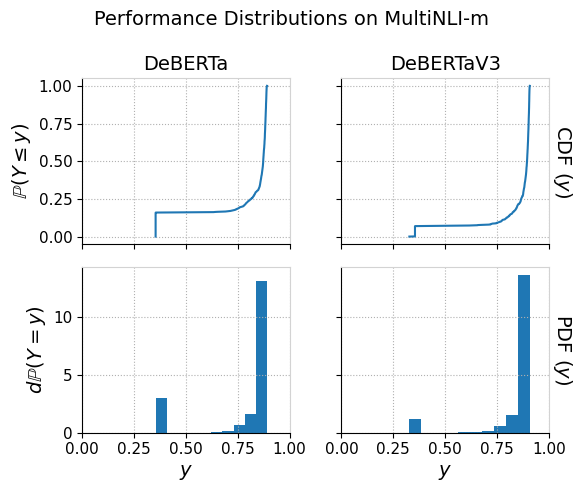

In [10]:
# Plot the performance distributions.
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=True,
    sharey='row',
    figsize=(6, 5),
)
for j, model_ in enumerate(models):
    visualization.plot_distribution(
        model_to_evaluation_to_ys[model_][evaluation],
        'y',
        axes=axes[:, j]
    )
    
# Format the plots.

# Collect titles in order to move them to the right side of the figure.
row_titles = [set() for _ in range(2)]
for i in range(2):
    for j, _ in enumerate(models):
        row_titles[i].add(axes[i, j].get_title())

for i, titles in enumerate(row_titles):
    if len(titles) != 1:
        raise RuntimeError(
            'Found multiple titles for the row.'
        )
    title = next(iter(titles))

    for j in range(1, len(models)):
        axes[i, j].set_ylabel(None)

    axes[i, -1].yaxis.set_label_position('right')
    axes[i, -1].set_ylabel(title, labelpad=18, rotation=270)

for j, model_ in enumerate(models):
    for i in range(1):
        axes[i, j].set_xlabel(None)
        
    for i in range(2):
        axes[i, j].set_title(None)
        
    axes[0, j].set_title(models[model_]['name'])

for i in range(len(models)):
    for j in range(2):
        axes[i, j].set_xlim(y_min, y_max)
        axes[i, j].spines['right'].set_color('lightgrey')
        axes[i, j].spines['top'].set_color('lightgrey')

fig.suptitle(
    f'Performance Distributions on {evaluations[evaluation]["name"]}'
)

fig.tight_layout()

plt.show()

Next, let's check how closely the empirical CDF approximates the true CDF. We can visualize the fit using our CDF confidence bands:

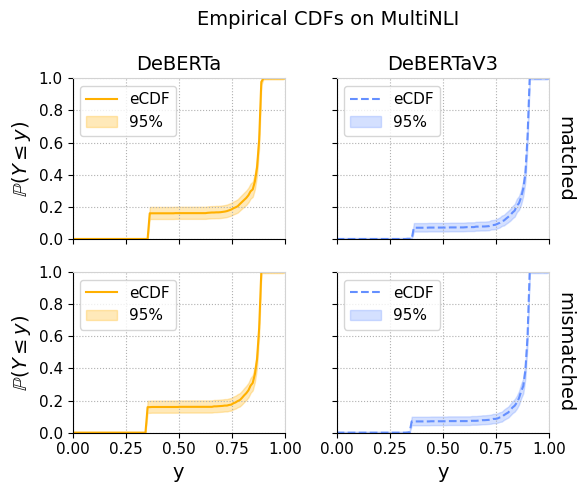

In [11]:
# Plot the CDFs with confidence bands.
fig, axes = plt.subplots(
    nrows=len(evaluations),
    ncols=len(models),
    sharex=True,
    sharey=True,
    figsize=(6, 5),
)
for i, evaluation_ in enumerate(evaluations):
    for j, model_ in enumerate(models):
        lower_cdf, point_cdf, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                model_to_evaluation_to_ys[model_][evaluation_],
                confidence=cdf_confidence,
                a=y_min,
                b=y_max,
                method=band,
            )

        # Plot the confidence bands.
        axes[i, j].plot(
            grid,
            point_cdf.cdf(grid),
            label='eCDF',
            **models[model_]['style'],
        )
        axes[i, j].fill_between(
            grid,
            upper_cdf.cdf(grid),
            lower_cdf.cdf(grid),
            alpha=0.275,
            label=f'{cdf_confidence * 100:.0f}%',
            color=models[model_]['style']['color'],
        )

# Format the plots.
for j, model_ in enumerate(models):
    axes[1, j].set_xlabel('y')
    axes[0, j].set_title(models[model_]['name'])
    
for i, evaluation_ in enumerate(evaluations):
    axes[i, 0].set_ylabel(r'$\mathbb{{P}}(Y \leq y)$')
    axes[i, -1].yaxis.set_label_position('right')
    axes[i, -1].set_ylabel(evaluation_, labelpad=18, rotation=270)

for i in range(len(evaluations)):
    for j in range(len(models)):
        axes[i, j].set_xlim(y_min, y_max)
        axes[i, j].set_ylim(0., 1.)
        axes[i, j].spines['right'].set_color('lightgrey')
        axes[i, j].spines['top'].set_color('lightgrey')
        axes[i, j].legend(loc='upper left')

fig.suptitle(
    'Empirical CDFs on MultiNLI',
    x=0.56,
)

fig.tight_layout()

plt.show()

Due to our large sample size of 1,024 search iterations, the confidence bands are extremely narrow and thus the empirical CDF approximates the true CDF very well for all models and evaluation test sets.

#### Choosing the KDE Bandwidth

The most important hyperparameter in KDE is the bandwidth. Intuitively, we'd like our simulation to behave like resampling except with the discretization effects removed. Thus, we want a relatively small bandwidth that preserves the distribution's shape. Cross-validation tends to encourage oversmoothing in order to cover unseen points with high likelihood. Instead, we will select the bandwidth visually.

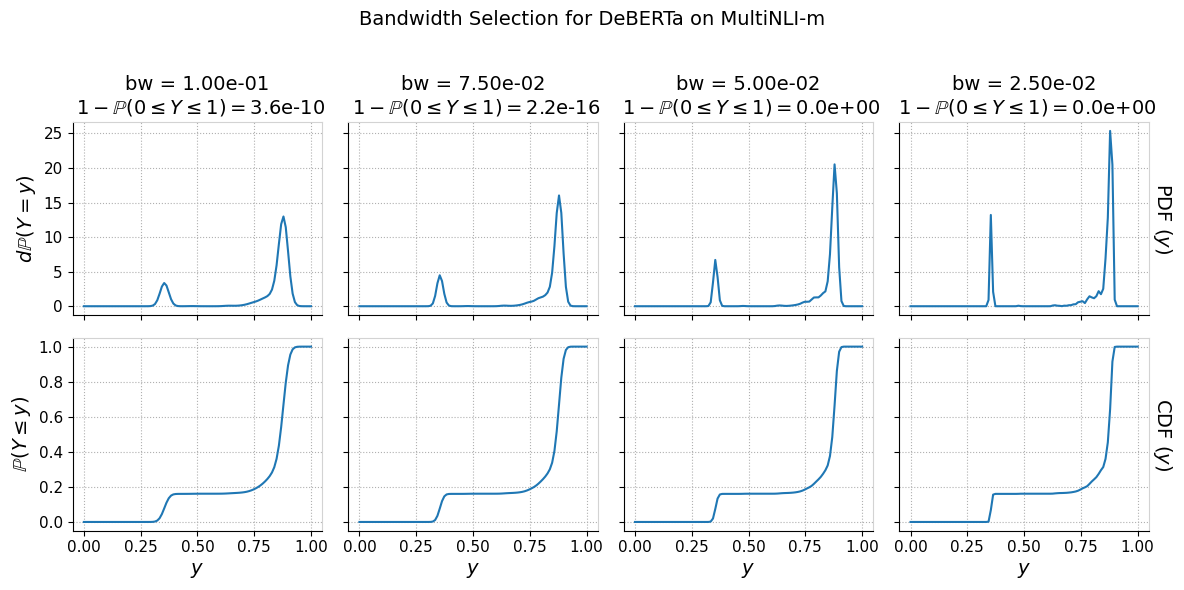

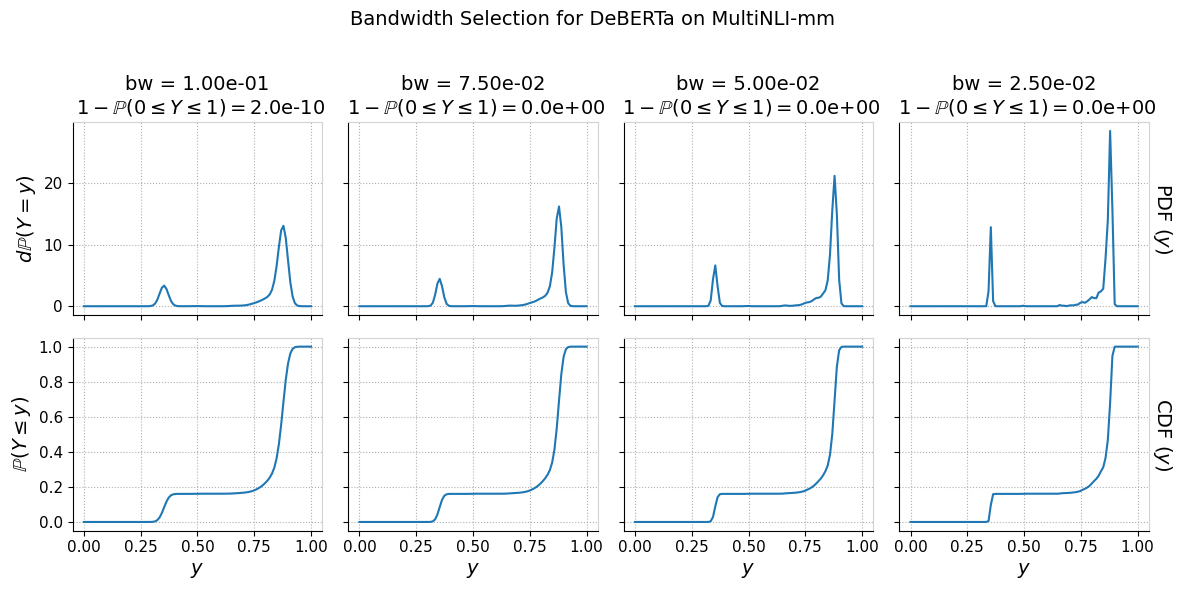

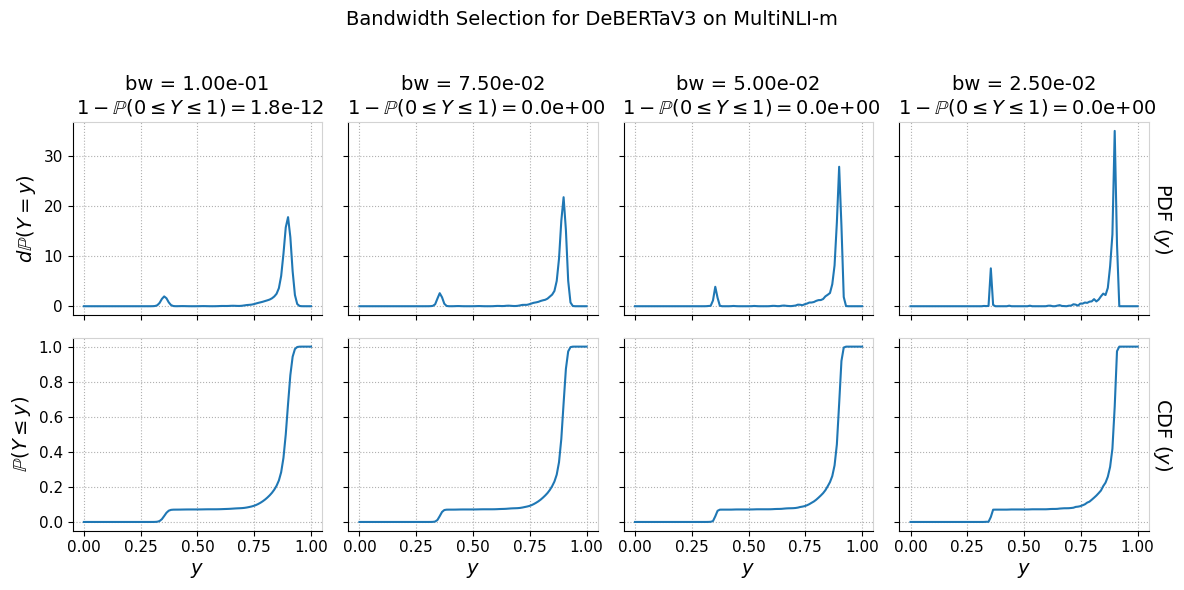

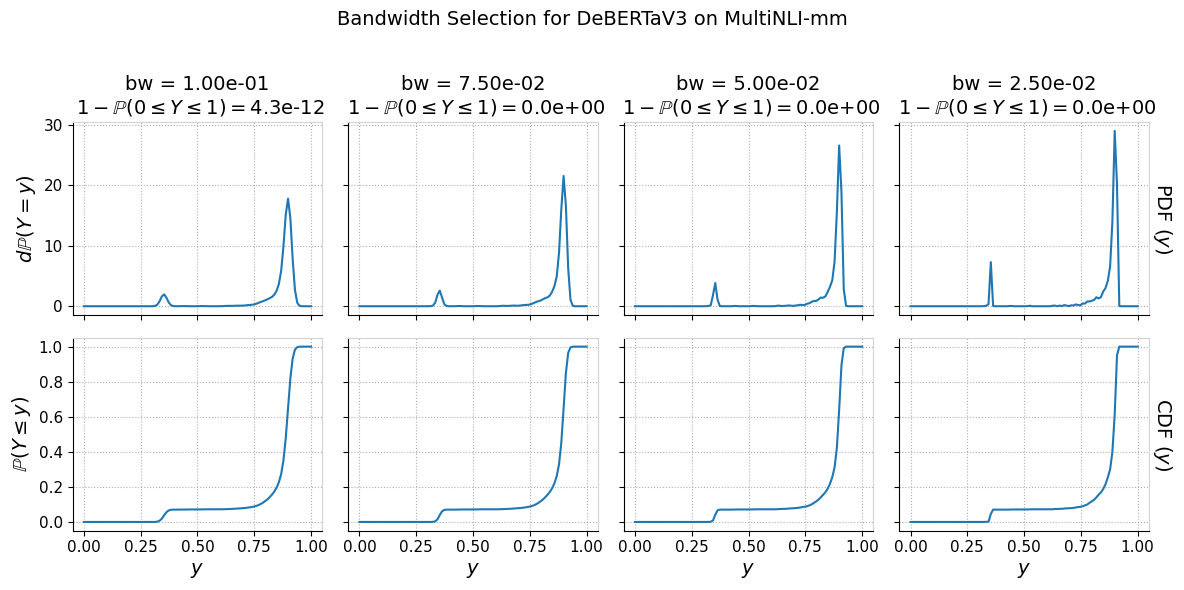

In [12]:
# Plot the distribution for various bandwidths.
for model_ in models:
    for evaluation_ in evaluations:
        fig, axes = plt.subplots(
            nrows=len(models),
            ncols=len(bws),
            sharex=True,
            sharey='row',
            figsize=(12, 6),
        )
        total_probabilities = []
        for j, bw in enumerate(bws):
            kde = stats.gaussian_kde(
                model_to_evaluation_to_ys[model_][evaluation_], 
                bw_method=bw,
            )

            total_probabilities.append(kde.integrate_box_1d(0, 1))

            axes[0, j].plot(
                grid,
                kde.pdf(grid),
            )
            axes[1, j].plot(
                grid, 
                [kde.integrate_box_1d(y_min, y) for y in grid],
            )
        
        # Format the plots.
        for j, (bw, total_probability) in enumerate(
            zip(bws, total_probabilities)
        ):
            axes[1, j].set_xlabel('$y$')
            axes[0, j].set_title(
                 f'bw = {bw:.2e}\n'
                rf' $1 - \mathbb{{P}}(0\leq Y\leq 1)=${1-total_probability:.1e}'
            )

        for i, kind in enumerate(['PDF ($y$)', 'CDF ($y$)']):
            axes[i, -1].yaxis.set_label_position('right')
            axes[i, -1].set_ylabel(kind, labelpad=18, rotation=270)

        axes[0, 0].set_ylabel(r'$d\mathbb{{P}}(Y = y)$')
        axes[1, 0].set_ylabel(r'$\mathbb{{P}}(Y \leq y)$')

        for i in range(2):
            for j in range(len(bws)):
                axes[i, j].spines['right'].set_color('lightgrey')
                axes[i, j].spines['top'].set_color('lightgrey')

        fig.suptitle(
            f'Bandwidth Selection for {models[model_]["name"]}'
            f' on {evaluations[evaluation_]["name"]}\n'
        )

        fig.tight_layout()

        plt.show()

From the above plots, a bandwidth of 0.05 seem to strike a reasonable trade off for all model evaluation pairs.

One challenge for KDE is estimating the distribution near the boundary. Kernels near the boundary tend to spill probability mass over it. Restricting to inside the bounds and renormalizing the distribution creates bias that makes the density estimates at the boundary inconsistent. There are various ways to correct this boundary bias. In the above plots, we see that almost all of the probability mass from the KDE estimate stays within the bounds&mdash;to the point that our numerical calculations round the mass outside the boundary to zero for smaller bandwidths (0.05 and 0.025). We could attempt to correct for the unknown ends of the support; however, such corrections for unknown bounds are more complicated and the boundary bias in this case affects only the density estimate and not so much the sampling or CDF. Thus, a boundary correction is unnecessary for this experiment.

### Computing the Confidence Bands' Simultaneous Coverage

Now that we have our simulation, we can empirically assess the confidence bands' coverage.

First, let's evaluate the coverage for the *CDF* confidence bands. Using our KDE, we can sample from the simulated performance distribution, construct the confidence bands, and then measure their coverage empirically.

In [13]:
# Compute the empirical coverage for each model/evaluation pair.
model_to_evaluation_to_coverage = {
    model_: {
        evaluation_: [[], [], []]
        for evaluation_ in evaluations
    }
    for model_ in models
}
for model_ in models:
    for evaluation_ in evaluations:
        # Construct the KDE simulation for the model/evaluation.
        kde = stats.gaussian_kde(
            model_to_evaluation_to_ys[model_][evaluation_],
            bw_method=bw,
        )
        for confidence_ in confidences:
            n_covered = 0
            for _ in range(n_trials):
                # Sample from the simulation.
                ys = kde.resample(n).squeeze()

                # Construct the confidence bands.
                lower_cdf, _, upper_cdf =\
                    nonparametric.EmpiricalDistribution.confidence_bands(
                        ys,
                        confidence=confidence_,
                        a=y_min,
                        b=y_max,
                        method=band,
                    )

                # Test if the confidence bands cover the true CDF.
                covered = True
                # NOTE: We only need to test for violations at and just
                # before the order statistics, since the confidence
                # bands are step functions.
                for test_point in [
                    y_min,
                    *(ys - 1e-15),
                    *ys,
                    y_max,
                ]:
                    true_cdf_value = kde.integrate_box_1d(y_min, test_point)
                    covered = covered and (
                        lower_cdf.cdf(test_point) <= true_cdf_value
                    ) & (
                        true_cdf_value <= upper_cdf.cdf(test_point)
                    )
                    if not covered:
                        break

                n_covered += covered
    
            coverage = n_covered / n_trials
            lo, hi = utils.binomial_confidence_interval(
                n_successes=n_covered,
                n_total=n_trials,
                confidence=coverage_confidence,
            )

            model_to_evaluation_to_coverage\
                [model_][evaluation_][0].append(lo)
            model_to_evaluation_to_coverage\
                [model_][evaluation_][1].append(coverage)
            model_to_evaluation_to_coverage\
                [model_][evaluation_][2].append(hi)
            
for model_ in models:
    for evaluation_ in evaluations:
        model_to_evaluation_to_coverage[model_][evaluation_] = tuple(
            map(np.array, model_to_evaluation_to_coverage[model_][evaluation_])
        )

Now that we have the empirical coverages, we can plot them against the nominal confidence levels:

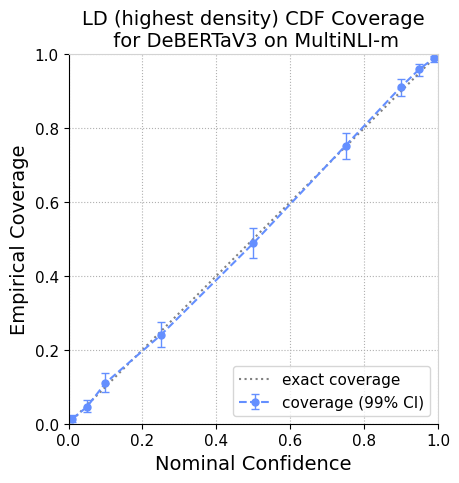

In [14]:
coverage_los, coverages, coverage_his =\
    model_to_evaluation_to_coverage[model][evaluation]

# Plot the nominal vs. empirical coverage of the CDF bands.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.errorbar(
    confidences.keys(),
    coverages,
    yerr=np.abs(coverages - np.stack([coverage_los, coverage_his])),
    marker='o',
    markersize=5,
    elinewidth=1,
    capsize=3,
    capthick=1,
    label=f'coverage ({100*coverage_confidence:.0f}% CI)',
    **models[model]['style'],
)
ax.plot(
    [0, 1],
    [0, 1],
    color='grey',
    linestyle=':',
    label='exact coverage',
)

# Format the plot.
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.legend(loc='lower right')
ax.set_xlabel('Nominal Confidence')
ax.set_ylabel('Empirical Coverage')
ax.set_title(
    f'{bands[band]["name"]} CDF Coverage\n'
    f' for {models[model]["name"]} on {evaluations[evaluation]["name"]}'
)
ax.set_aspect('equal')

fig.tight_layout()

plt.show()

As predicted by the theory, the CDF confidence bands have exact coverage in practice.

We can also produce the same plot for all models and evaluations:

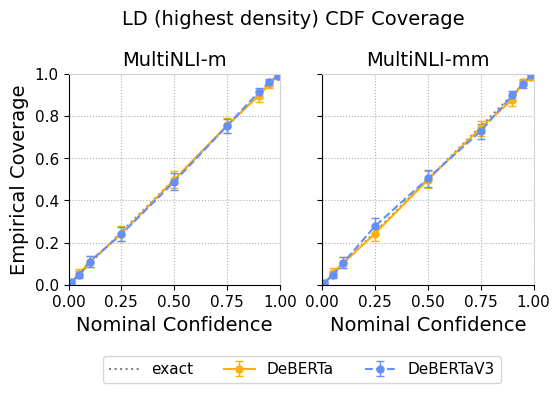

In [15]:
# Plot the nominal vs. empirical coverage of the CDF bands for all
# model/evaluation pairs.
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(6, 3.5),
)
for i, evaluation_ in enumerate(evaluations):
    for model_ in models:
        coverage_los, coverages, coverage_his =\
            model_to_evaluation_to_coverage[model_][evaluation_]

        axes[i].errorbar(
            confidences.keys(),
            coverages,
            yerr=np.abs(coverages - np.stack([coverage_los, coverage_his])),
            marker='o',
            markersize=5,
            elinewidth=1,
            capsize=3,
            capthick=1,
            label=models[model_]["name"],
            **models[model_]['style'],
        )

    axes[i].plot(
        [0, 1],
        [0, 1],
        color='grey',
        linestyle=':',
        label='exact',
    )

# Format the plot.
for i, evaluation_ in enumerate(evaluations):
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)
    axes[i].set_aspect('equal')
    axes[i].spines['right'].set_color('lightgrey')
    axes[i].spines['top'].set_color('lightgrey')
    axes[i].set_xlabel('Nominal Confidence')
    axes[i].set_title(evaluations[evaluation_]["name"])
    
axes[0].set_ylabel('Empirical Coverage')
axes[0].legend(
    loc='lower left',
    bbox_to_anchor=(0.125, -0.5),
    ncol=len(models) + 1,
)

fig.suptitle(f'{bands[band]["name"]} CDF Coverage')

plt.show()

Again, in line with the theory, we observe exact coverage for all models and evaluation test sets.

Now, let's evaluate the coverage for the *tuning curve* confidence bands. Again, we'll sample from the simulated performance distribution, construct the confidence bands, and measure their coverage empirically.

In [16]:
# Compute the empirical coverage for each model/evaluation pair.
model_to_evaluation_to_coverage = {
    model_: {
        evaluation_: [[], [], []]
        for evaluation_ in evaluations
    }
    for model_ in models
}
for model_ in models:
    for evaluation_ in evaluations:
        # Construct the KDE simulation for the model/evaluation.
        kde = stats.gaussian_kde(
            model_to_evaluation_to_ys[model_][evaluation_],
            bw_method=bw,
        )
        for confidence_ in confidences:
            n_covered = 0
            for _ in range(n_trials):
                # Sample from the simulation.
                ys = kde.resample(n).squeeze()

                # Construct the confidence bands.
                lower_cdf, _, upper_cdf =\
                    nonparametric.EmpiricalDistribution.confidence_bands(
                        ys,
                        confidence=confidence_,
                        a=y_min,
                        b=y_max,
                        method=band,
                    )

                # Test if the confidence bands cover the true tuning
                # curve.
                covered = True
                # NOTE: Since the confidence bands are step functions
                # and the tuning curve is monotonic, we only need to
                # test around values of k such that the k'th power of
                # the CDF at an order statistic equals 0.5.
                #
                # Moreover, we don't have to test at points where the
                # lower CDF is 0 or the upper CDF is 1 since these
                # points are always covered if the adjacent points are
                # covered (at those discontinuities the lower/upper
                # band jumps down/up to the support's bounds).
                order_statistics = np.sort(ys)
                
                # Check for violations of the lower band.
                order_statistic_quantiles = upper_cdf.cdf(order_statistics)
                order_statistic_quantiles = order_statistic_quantiles[
                    order_statistic_quantiles < 1.
                ]
                test_points = (
                    # w^k = 0.5 implies k = log(0.5) / log(w)
                    (
                        np.log(0.5)
                        / np.log(order_statistic_quantiles)
                    )[:, None]
                    + np.array([-1e-8, 1e-8])[None, :]
                ).reshape(-1)
                lower_tuning_curve_points =\
                    upper_cdf.quantile_tuning_curve(test_points)
                for test_point, lower_point in zip(
                    test_points, lower_tuning_curve_points,
                ):
                    if not covered:
                        break

                    covered = covered and (
                        kde.integrate_box_1d(y_min, lower_point)**test_point
                        <= 0.5 
                    )

                # Check for violations of the upper band.
                order_statistic_quantiles = lower_cdf.cdf(order_statistics)
                order_statistic_quantiles = order_statistic_quantiles[
                    order_statistic_quantiles > 0.
                ]
                test_points = (
                    (
                        np.log(0.5)
                        / np.log(order_statistic_quantiles)
                    )[:, None]
                    + np.array([-1e-8, 1e-8])[None, :]
                ).reshape(-1)
                upper_tuning_curve_points =\
                    lower_cdf.quantile_tuning_curve(test_points)
                for test_point, upper_point in zip(
                    test_points, upper_tuning_curve_points,
                ):
                    if not covered:
                        break

                    covered = covered and (
                        0.5 
                        <= kde.integrate_box_1d(y_min, upper_point)**test_point
                    )

                n_covered += covered
    
            coverage = n_covered / n_trials
            lo, hi = utils.binomial_confidence_interval(
                n_successes=n_covered,
                n_total=n_trials,
                confidence=coverage_confidence,
            )

            model_to_evaluation_to_coverage\
                [model_][evaluation_][0].append(lo)
            model_to_evaluation_to_coverage\
                [model_][evaluation_][1].append(coverage)
            model_to_evaluation_to_coverage\
                [model_][evaluation_][2].append(hi)
            
for model_ in models:
    for evaluation_ in evaluations:
        model_to_evaluation_to_coverage[model_][evaluation_] = tuple(
            map(np.array, model_to_evaluation_to_coverage[model_][evaluation_])
        )

Let's plot the empirical coverage against the nominal confidence levels:

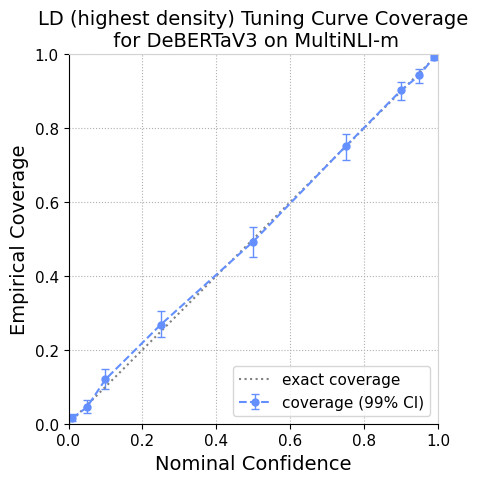

In [17]:
coverage_los, coverages, coverage_his =\
    model_to_evaluation_to_coverage[model][evaluation]

# Plot the nominal vs. empirical coverage of the tuning curve bands.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.errorbar(
    confidences.keys(),
    coverages,
    yerr=np.abs(coverages - np.stack([coverage_los, coverage_his])),
    marker='o',
    markersize=5,
    elinewidth=1,
    capsize=3,
    capthick=1,
    label=f'coverage ({100*coverage_confidence:.0f}% CI)',
    **models[model]['style'],
)
ax.plot(
    [0, 1],
    [0, 1],
    color='grey',
    linestyle=':',
    label='exact coverage',
)

# Format the plot.
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.legend(loc='lower right')
ax.set_xlabel('Nominal Confidence')
ax.set_ylabel('Empirical Coverage')
ax.set_title(
    f'{bands[band]["name"]} Tuning Curve Coverage\n'
    f' for {models[model]["name"]} on {evaluations[evaluation]["name"]}'
)
ax.set_aspect('equal')

fig.tight_layout()

plt.show()

As theory predicts, the median tuning curve confidence bands show exact coverage empirically.

Finally, we'll produce the same plot for all models and evaluations:

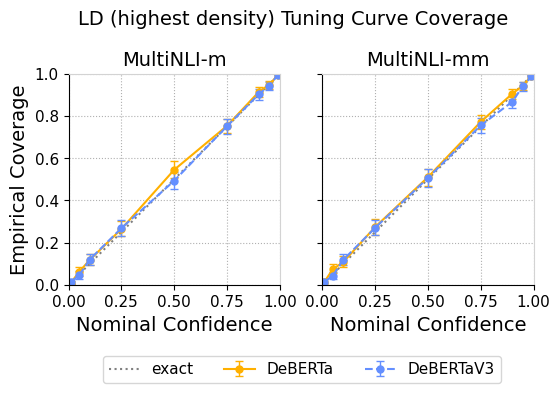

In [18]:
# Plot the nominal vs. empirical coverage of the tuning curve bands for
# all model/evaluation pairs.
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(6, 3.5),
)
for i, evaluation_ in enumerate(evaluations):
    for model_ in models:
        coverage_los, coverages, coverage_his =\
            model_to_evaluation_to_coverage[model_][evaluation_]

        axes[i].errorbar(
            confidences.keys(),
            coverages,
            yerr=np.abs(coverages - np.stack([coverage_los, coverage_his])),
            marker='o',
            markersize=5,
            elinewidth=1,
            capsize=3,
            capthick=1,
            label=models[model_]["name"],
            **models[model_]['style'],
        )

    axes[i].plot(
        [0, 1],
        [0, 1],
        color='grey',
        linestyle=':',
        label='exact',
    )

# Format the plot.
for i, evaluation_ in enumerate(evaluations):
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)
    axes[i].set_aspect('equal')
    axes[i].spines['right'].set_color('lightgrey')
    axes[i].spines['top'].set_color('lightgrey')
    axes[i].set_xlabel('Nominal Confidence')
    axes[i].set_title(evaluations[evaluation_]["name"])
    
axes[0].set_ylabel('Empirical Coverage')
axes[0].legend(
    loc='lower left',
    bbox_to_anchor=(0.125, -0.5),
    ncol=len(models) + 1,
)

fig.suptitle(f'{bands[band]["name"]} Tuning Curve Coverage')

plt.show()

## Ablation Studies

A natural question to ask is which aspects of the confidence bands' design are important or necessary. To explore this question, we'll run a few ablation studies to show what happens if we change different parts of the formula.

### DKW vs. KS vs. LD CDF Bands

Our general technique is to translate simultaneous confidence bands for the CDF into simultaneous confidence bands for the tuning curve. Hypothetically, we could start from any simultaneous confidence bands for the CDF. Other bands are easier to compute than the Learned-Miller DeStefano (LD) bands, and perhaps they'd lead to tighter confidence limits on the tuning curve.

As described in [**Nonparametric Analysis**](../theory/nonparametric-analysis.ipynb#Bounding-the-CDF), the main alternative CDF bands are the Dvoretzky-Kiefer-Wolfowitz and the Kolmogorov-Smirnov bands. Let's compare the three for bounding the CDF:

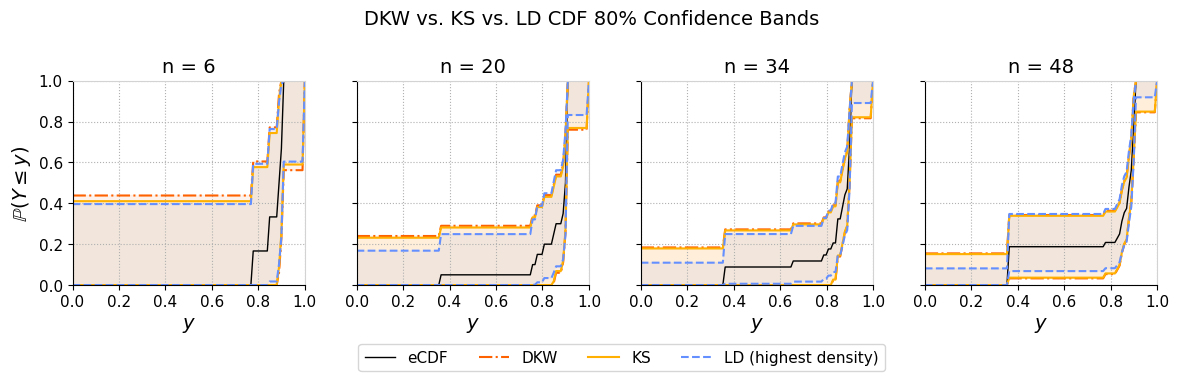

In [19]:
fig, axes = plt.subplots(
    nrows=1, 
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 3.5),
)
for i, sample_size_ in enumerate(sample_sizes):
    ys = np.random.choice(
        model_to_evaluation_to_ys[model][evaluation],
        size=sample_size_,
        replace=False,
    )
    
    axes[i].plot(
        grid,
        nonparametric.EmpiricalDistribution(ys).cdf(grid),
        linewidth=1,
        linestyle='-',
        color='k',
        label='eCDF',
    )

    for band_ in ['dkw', 'ks', 'ld_highest_density']:
        lower_cdf, _, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band_,
            )
        
        axes[i].plot(
            grid,
            lower_cdf.cdf(grid),
            label=bands[band_]['name'],
            **bands[band_]['style'],
        )
        axes[i].plot(
            grid,
            upper_cdf.cdf(grid),
            **bands[band_]['style'],
        )
        axes[i].fill_between(
            grid,
            lower_cdf.cdf(grid),
            upper_cdf.cdf(grid),
            alpha=0.075,
            **bands[band_]['style'],
        )

# Format the plot.
axes[0].set_ylabel(r'$\mathbb{{P}}(Y \leq y)$')

for i, sample_size_ in enumerate(sample_sizes):
    axes[i].set_xlim(0., 1.)
    axes[i].set_ylim(0., 1.)
    axes[i].set_xlabel('$y$')
    axes[i].set_title(f'n = {sample_size_}')
    axes[i].spines['right'].set_color('lightgrey')
    axes[i].spines['top'].set_color('lightgrey')

fig.suptitle(
    f'DKW vs. KS vs. LD CDF {100 * confidence:.0f}% Confidence Bands'
)

fig.tight_layout()

axes[1].legend(
    loc='upper left',
    bbox_to_anchor=(-0.025, -0.25),
    ncol=4,
)

plt.show()

We see that for all except the smallest sample sizes, the LD bands are much tighter at the CDF's extremes and almost as tight as the others everywhere else.

This trend holds for both DeBERTa and DeBERTaV3's score distributions:

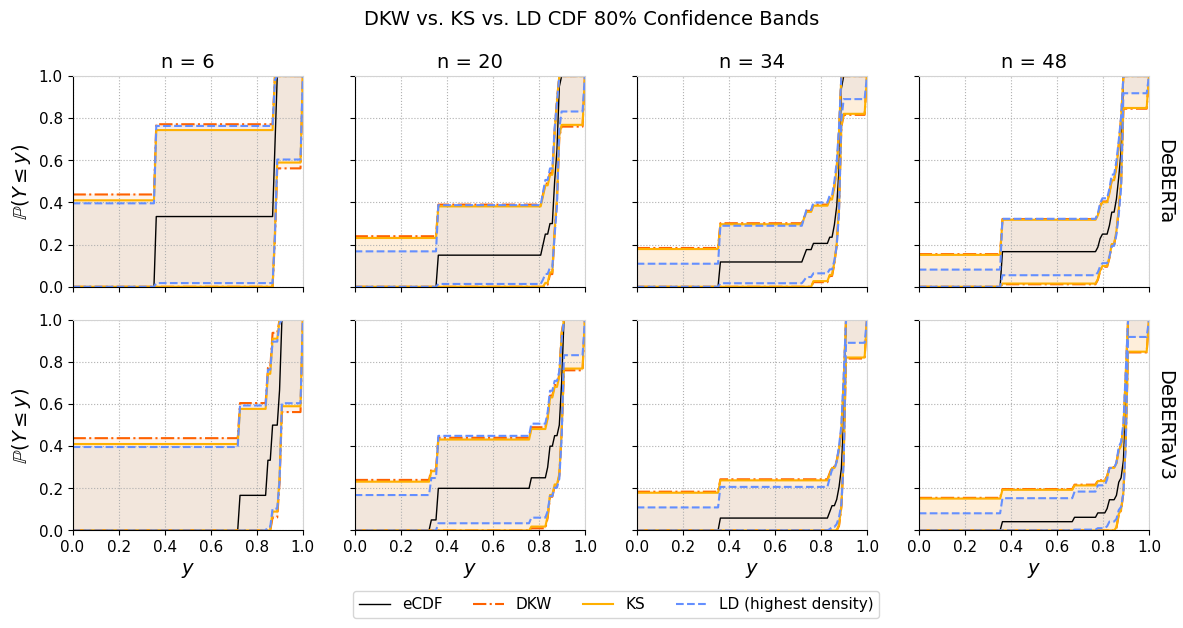

In [20]:
fig, axes = plt.subplots(
    nrows=2, 
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 6),
)
for i, model_ in enumerate(models):
    for j, sample_size_ in enumerate(sample_sizes):
        ys = np.random.choice(
            model_to_evaluation_to_ys[model_][evaluation],
            size=sample_size_,
            replace=False,
        )

        axes[i, j].plot(
            grid,
            nonparametric.EmpiricalDistribution(ys).cdf(grid),
            linewidth=1,
            linestyle='-',
            color='k',
            label='eCDF',
        )

        for band_ in ['dkw', 'ks', 'ld_highest_density']:
            lower_cdf, _, upper_cdf =\
                nonparametric.EmpiricalDistribution.confidence_bands(
                    ys,
                    confidence=confidence,
                    a=y_min,
                    b=y_max,
                    method=band_,
                )

            axes[i, j].plot(
                grid,
                lower_cdf.cdf(grid),
                label=bands[band_]['name'],
                **bands[band_]['style'],
            )
            axes[i, j].plot(
                grid,
                upper_cdf.cdf(grid),
                **bands[band_]['style'],
            )
            axes[i, j].fill_between(
                grid,
                lower_cdf.cdf(grid),
                upper_cdf.cdf(grid),
                alpha=0.075,
                **bands[band_]['style'],
            )

# Format the plot.
for j, sample_size_ in enumerate(sample_sizes):
    axes[1, j].set_xlabel('$y$')
    axes[0, j].set_title(f'n = {sample_size_}')
    
for i, model_ in enumerate(models):
    axes[i, 0].set_ylabel(r'$\mathbb{{P}}(Y \leq y)$')
    axes[i, -1].yaxis.set_label_position('right')
    axes[i, -1].set_ylabel(models[model_]['name'], labelpad=18, rotation=270)
        
for i in range(len(models)):
    for j in range(len(sample_sizes)):
        axes[i, j].set_xlim(0., 1.)
        axes[i, j].set_ylim(0., 1.)
        axes[i, j].spines['right'].set_color('lightgrey')
        axes[i, j].spines['top'].set_color('lightgrey')

fig.suptitle(
    f'DKW vs. KS vs. LD CDF {100 * confidence:.0f}% Confidence Bands'
)

fig.tight_layout()

axes[1, 1].legend(
    loc='upper left',
    bbox_to_anchor=(-0.04, -0.25),
    ncol=4,
)

plt.show()

So, how do these results for the CDF bands translate to the tuning curve bands?

First, let's compare the tuning curve confidence bands for the smallest and largest sample sizes:

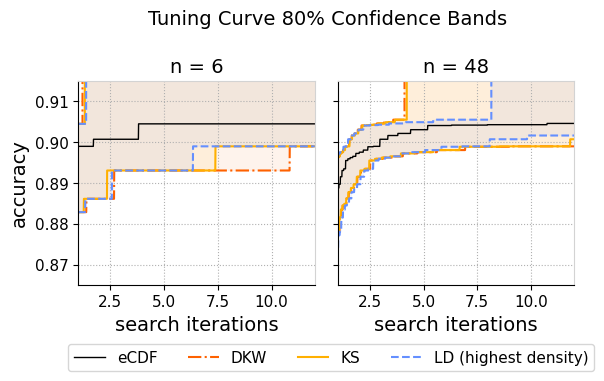

In [21]:
fig, axes = plt.subplots(
    nrows=1, 
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(6, 3.5),
)
for i, sample_size_ in enumerate([sample_sizes[0], sample_sizes[-1]]):
    ys = np.random.choice(
        model_to_evaluation_to_ys[model][evaluation],
        size=sample_size_,
        replace=False,
    )
    
    axes[i].plot(
        ns_grid,
        nonparametric.EmpiricalDistribution(ys).quantile_tuning_curve(ns_grid),
        linewidth=1,
        linestyle='-',
        color='k',
        label='eCDF',
    )

    for band_ in ['dkw', 'ks', 'ld_highest_density']:
        lower_cdf, _, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band_,
            )
        
        axes[i].plot(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            label=bands[band_]['name'],
            **bands[band_]['style'],
        )
        axes[i].plot(
            ns_grid,
            lower_cdf.quantile_tuning_curve(ns_grid),
            **bands[band_]['style'],
        )
        axes[i].fill_between(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            lower_cdf.quantile_tuning_curve(ns_grid),
            alpha=0.075,
            **bands[band_]['style'],
        )

# Format the plot.
axes[0].set_ylabel('accuracy')

for i, sample_size_ in enumerate([sample_sizes[0], sample_sizes[-1]]):
    axes[i].set_xlim(1, n // 4)
    axes[i].set_ylim(0.865, 0.915)
    axes[i].set_xlabel('search iterations')
    axes[i].set_title(f'n = {sample_size_}')
    axes[i].spines['right'].set_color('lightgrey')
    axes[i].spines['top'].set_color('lightgrey')

fig.suptitle(
    f'Tuning Curve {100 * confidence:.0f}% Confidence Bands',
    x=0.56,
)

fig.tight_layout()

axes[0].legend(
    loc='upper left',
    bbox_to_anchor=(-0.075, -0.25),
    ncol=4,
)

plt.show()

Because the LD (highest density) CDF confidence bands are much tighter at the upper extreme, the tuning curve bands extend much farther to the right before becoming trivial (jumping to the upper bound on $Y$'s support).

This finding holds across sample sizes:

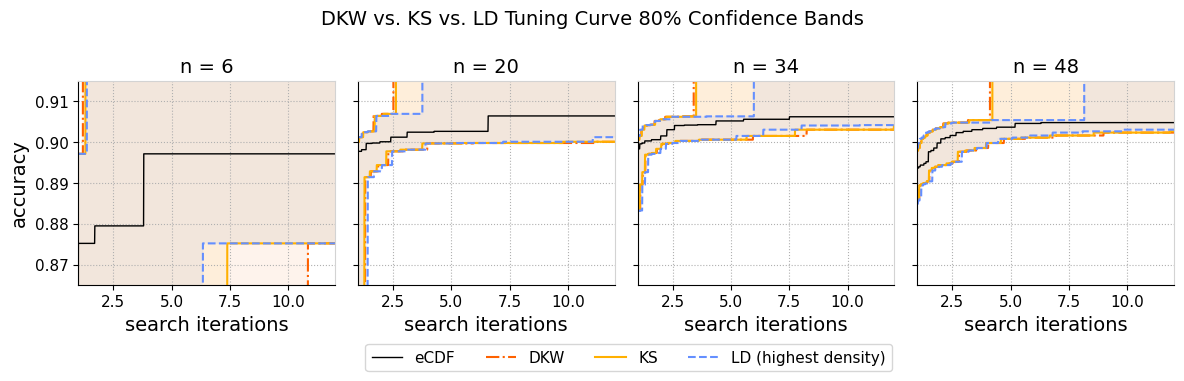

In [22]:
fig, axes = plt.subplots(
    nrows=1, 
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 3.5),
)
for i, sample_size_ in enumerate(sample_sizes):
    ys = np.random.choice(
        model_to_evaluation_to_ys[model][evaluation],
        size=sample_size_,
        replace=False,
    )
    
    axes[i].plot(
        ns_grid,
        nonparametric.EmpiricalDistribution(ys).quantile_tuning_curve(ns_grid),
        linewidth=1,
        linestyle='-',
        color='k',
        label='eCDF',
    )

    for band_ in ['dkw', 'ks', 'ld_highest_density']:
        lower_cdf, _, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band_,
            )
        
        axes[i].plot(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            label=bands[band_]['name'],
            **bands[band_]['style'],
        )
        axes[i].plot(
            ns_grid,
            lower_cdf.quantile_tuning_curve(ns_grid),
            **bands[band_]['style'],
        )
        axes[i].fill_between(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            lower_cdf.quantile_tuning_curve(ns_grid),
            alpha=0.075,
            **bands[band_]['style'],
        )

# Format the plot.
axes[0].set_ylabel('accuracy')

for i, sample_size_ in enumerate(sample_sizes):
    axes[i].set_xlim(1, n // 4)
    axes[i].set_ylim(0.865, 0.915)
    axes[i].set_xlabel('search iterations')
    axes[i].set_title(f'n = {sample_size_}')
    axes[i].spines['right'].set_color('lightgrey')
    axes[i].spines['top'].set_color('lightgrey')

fig.suptitle(
    f'DKW vs. KS vs. LD Tuning Curve {100 * confidence:.0f}% Confidence Bands'
)

fig.tight_layout()

axes[1].legend(
    loc='upper left',
    bbox_to_anchor=(0., -0.25),
    ncol=4,
)

plt.show()

as well as for both DeBERTa and DeBERTaV3:

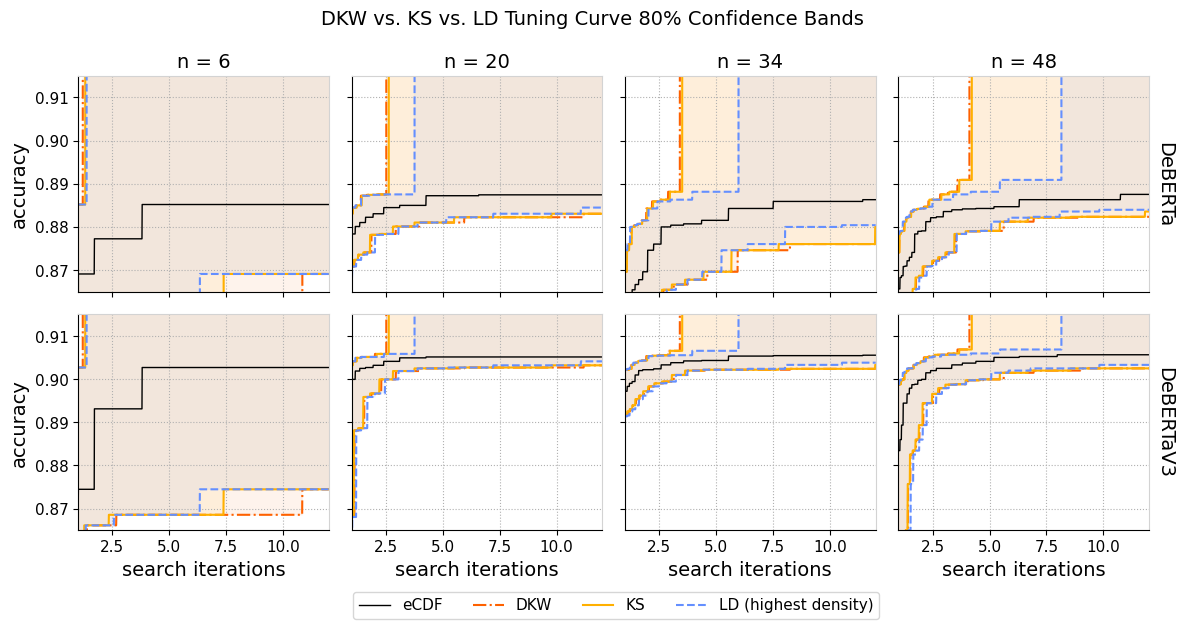

In [23]:
fig, axes = plt.subplots(
    nrows=2, 
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 6),
)
for i, model_ in enumerate(models):
    for j, sample_size_ in enumerate(sample_sizes):
        ys = np.random.choice(
            model_to_evaluation_to_ys[model_][evaluation],
            size=sample_size_,
            replace=False,
        )

        axes[i, j].plot(
            ns_grid,
            nonparametric.EmpiricalDistribution(ys).quantile_tuning_curve(ns_grid),
            linewidth=1,
            linestyle='-',
            color='k',
            label='eCDF',
        )

        for band_ in ['dkw', 'ks', 'ld_highest_density']:
            lower_cdf, _, upper_cdf =\
                nonparametric.EmpiricalDistribution.confidence_bands(
                    ys,
                    confidence=confidence,
                    a=y_min,
                    b=y_max,
                    method=band_,
                )

            axes[i, j].plot(
                ns_grid,
                upper_cdf.quantile_tuning_curve(ns_grid),
                label=bands[band_]['name'],
                **bands[band_]['style'],
            )
            axes[i, j].plot(
                ns_grid,
                lower_cdf.quantile_tuning_curve(ns_grid),
                **bands[band_]['style'],
            )
            axes[i, j].fill_between(
                ns_grid,
                upper_cdf.quantile_tuning_curve(ns_grid),
                lower_cdf.quantile_tuning_curve(ns_grid),
                alpha=0.075,
                **bands[band_]['style'],
            )

# Format the plot.
for j, sample_size_ in enumerate(sample_sizes):
    axes[1, j].set_xlabel('search iterations')
    axes[0, j].set_title(f'n = {sample_size_}')
    
for i, model_ in enumerate(models):
    axes[i, 0].set_ylabel('accuracy')
    axes[i, -1].yaxis.set_label_position('right')
    axes[i, -1].set_ylabel(models[model_]['name'], labelpad=18, rotation=270)
        
for i in range(len(models)):
    for j in range(len(sample_sizes)):
        axes[i, j].set_xlim(1, n // 4)
        axes[i, j].set_ylim(0.865, 0.915)
        axes[i, j].spines['right'].set_color('lightgrey')
        axes[i, j].spines['top'].set_color('lightgrey')

fig.suptitle(
    f'DKW vs. KS vs. LD Tuning Curve {100 * confidence:.0f}% Confidence Bands'
)

fig.tight_layout()

axes[1, 1].legend(
    loc='upper left',
    bbox_to_anchor=(-0.025, -0.25),
    ncol=4,
)

plt.show()

### Equal-tailed vs. Highest Density

The second innovation we recommend in the [**Nonparametric Analysis**](../theory/nonparametric-analysis.ipynb#Bounding-the-CDF) is to use the *highest probability density* intervals when constructing the LD bands, rather than the *equal-tailed* intervals originally used by [Learned-Miller and DeStefano (2005)](http://vis-www.cs.umass.edu/papers/IT_ent_bound.pdf).

Highest probability density intervals are more expensive to compute than equal-tailed intervals; however, they produce tighter confidence bands, since the highest density interval is also the shortest interval with a given coverage. We can see this effect in the following plot:

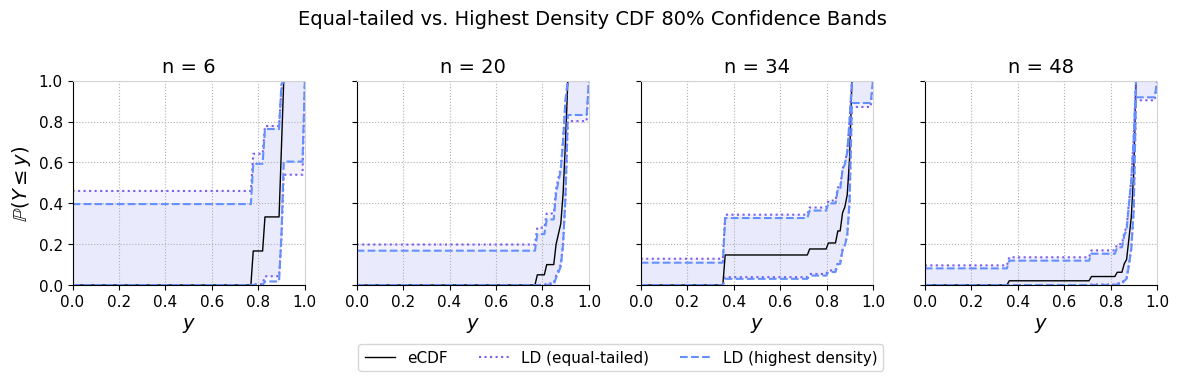

In [24]:
fig, axes = plt.subplots(
    nrows=1, 
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 3.5),
)
for i, sample_size_ in enumerate(sample_sizes):
    ys = np.random.choice(
        model_to_evaluation_to_ys[model][evaluation],
        size=sample_size_,
        replace=False,
    )
    
    axes[i].plot(
        grid,
        nonparametric.EmpiricalDistribution(ys).cdf(grid),
        linewidth=1,
        linestyle='-',
        color='k',
        label='eCDF',
    )

    for band_ in ['ld_equal_tailed', 'ld_highest_density']:
        lower_cdf, _, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band_,
            )
        
        axes[i].plot(
            grid,
            lower_cdf.cdf(grid),
            label=bands[band_]['name'],
            **bands[band_]['style'],
        )
        axes[i].plot(
            grid,
            upper_cdf.cdf(grid),
            **bands[band_]['style'],
        )
        axes[i].fill_between(
            grid,
            lower_cdf.cdf(grid),
            upper_cdf.cdf(grid),
            alpha=0.075,
            **bands[band_]['style'],
        )

# Format the plot.
axes[0].set_ylabel(r'$\mathbb{{P}}(Y \leq y)$')

for i, sample_size_ in enumerate(sample_sizes):
    axes[i].set_xlim(0., 1.)
    axes[i].set_ylim(0., 1.)
    axes[i].set_xlabel('$y$')
    axes[i].set_title(f'n = {sample_size_}')
    axes[i].spines['right'].set_color('lightgrey')
    axes[i].spines['top'].set_color('lightgrey')

fig.suptitle(
    f'Equal-tailed vs. Highest Density CDF {100 * confidence:.0f}% Confidence Bands'
)

fig.tight_layout()

axes[1].legend(
    loc='upper left',
    bbox_to_anchor=(-0.025, -0.25),
    ncol=3,
)

plt.show()

Again, the result is the same for both DeBERTa and DeBERTaV3:

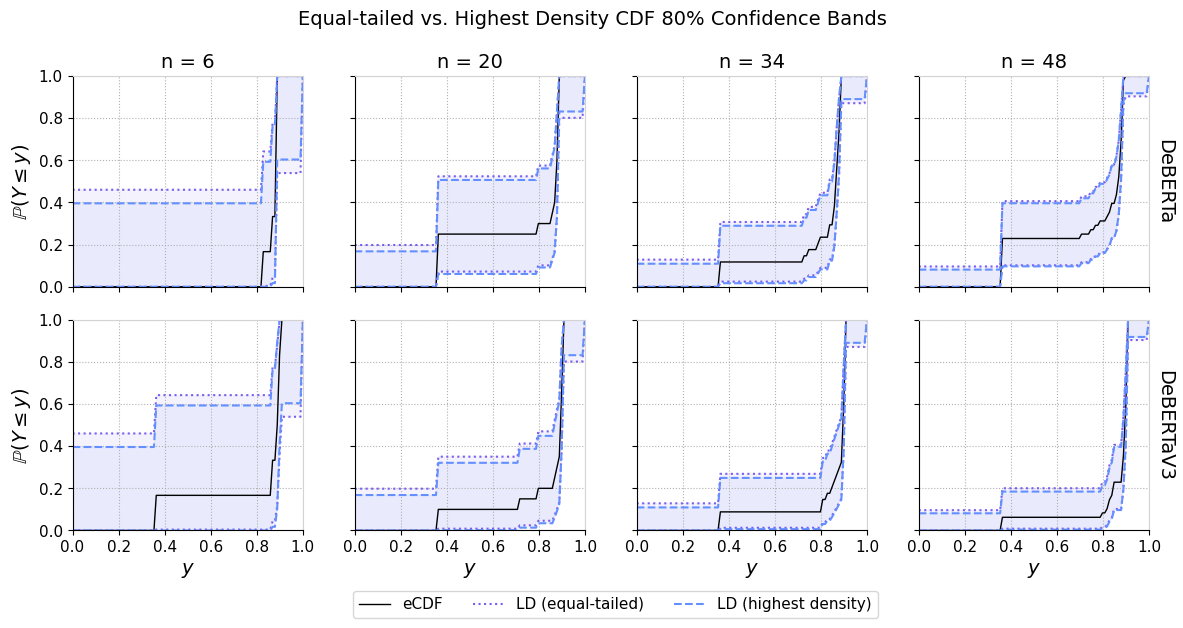

In [25]:
fig, axes = plt.subplots(
    nrows=2, 
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 6),
)
for i, model_ in enumerate(models):
    for j, sample_size_ in enumerate(sample_sizes):
        ys = np.random.choice(
            model_to_evaluation_to_ys[model_][evaluation],
            size=sample_size_,
            replace=False,
        )

        axes[i, j].plot(
            grid,
            nonparametric.EmpiricalDistribution(ys).cdf(grid),
            linewidth=1,
            linestyle='-',
            color='k',
            label='eCDF',
        )

        for band_ in ['ld_equal_tailed', 'ld_highest_density']:
            lower_cdf, _, upper_cdf =\
                nonparametric.EmpiricalDistribution.confidence_bands(
                    ys,
                    confidence=confidence,
                    a=y_min,
                    b=y_max,
                    method=band_,
                )

            axes[i, j].plot(
                grid,
                lower_cdf.cdf(grid),
                label=bands[band_]['name'],
                **bands[band_]['style'],
            )
            axes[i, j].plot(
                grid,
                upper_cdf.cdf(grid),
                **bands[band_]['style'],
            )
            axes[i, j].fill_between(
                grid,
                lower_cdf.cdf(grid),
                upper_cdf.cdf(grid),
                alpha=0.075,
                **bands[band_]['style'],
            )

# Format the plot.
for j, sample_size_ in enumerate(sample_sizes):
    axes[1, j].set_xlabel('$y$')
    axes[0, j].set_title(f'n = {sample_size_}')
    
for i, model_ in enumerate(models):
    axes[i, 0].set_ylabel(r'$\mathbb{{P}}(Y \leq y)$')
    axes[i, -1].yaxis.set_label_position('right')
    axes[i, -1].set_ylabel(models[model_]['name'], labelpad=18, rotation=270)
        
for i in range(len(models)):
    for j in range(len(sample_sizes)):
        axes[i, j].set_xlim(0., 1.)
        axes[i, j].set_ylim(0., 1.)
        axes[i, j].spines['right'].set_color('lightgrey')
        axes[i, j].spines['top'].set_color('lightgrey')

fig.suptitle(
    f'Equal-tailed vs. Highest Density CDF {100 * confidence:.0f}% Confidence Bands'
)

fig.tight_layout()

axes[1, 1].legend(
    loc='upper left',
    bbox_to_anchor=(-0.04, -0.25),
    ncol=3,
)

plt.show()

Let's see how these results translate to tuning curves. Starting with the smallest and largest sample size:

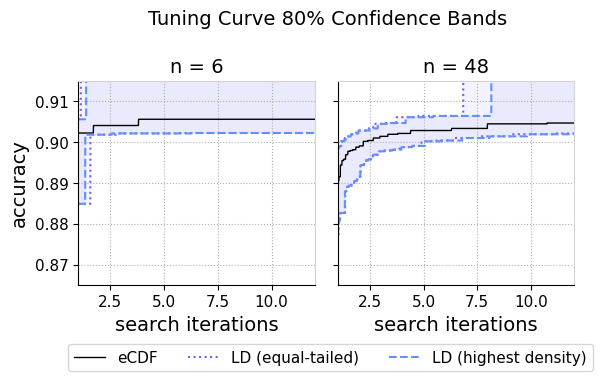

In [26]:
fig, axes = plt.subplots(
    nrows=1, 
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(6, 3.5),
)
for i, sample_size_ in enumerate([sample_sizes[0], sample_sizes[-1]]):
    ys = np.random.choice(
        model_to_evaluation_to_ys[model][evaluation],
        size=sample_size_,
        replace=False,
    )
    
    axes[i].plot(
        ns_grid,
        nonparametric.EmpiricalDistribution(ys).quantile_tuning_curve(ns_grid),
        linewidth=1,
        linestyle='-',
        color='k',
        label='eCDF',
    )

    for band_ in ['ld_equal_tailed', 'ld_highest_density']:
        lower_cdf, _, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band_,
            )
        
        axes[i].plot(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            label=bands[band_]['name'],
            **bands[band_]['style'],
        )
        axes[i].plot(
            ns_grid,
            lower_cdf.quantile_tuning_curve(ns_grid),
            **bands[band_]['style'],
        )
        axes[i].fill_between(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            lower_cdf.quantile_tuning_curve(ns_grid),
            alpha=0.075,
            **bands[band_]['style'],
        )

# Format the plot.
axes[0].set_ylabel('accuracy')

for i, sample_size_ in enumerate([sample_sizes[0], sample_sizes[-1]]):
    axes[i].set_xlim(1, n // 4)
    axes[i].set_ylim(0.865, 0.915)
    axes[i].set_xlabel('search iterations')
    axes[i].set_title(f'n = {sample_size_}')
    axes[i].spines['right'].set_color('lightgrey')
    axes[i].spines['top'].set_color('lightgrey')

fig.suptitle(
    f'Tuning Curve {100 * confidence:.0f}% Confidence Bands',
    x=0.56,
)

fig.tight_layout()

axes[0].legend(
    loc='upper left',
    bbox_to_anchor=(-0.075, -0.25),
    ncol=3,
)

plt.show()

The upper tuning curve confidence band becomes notably tighter, giving a non-trivial bound over a greater range with the highest probability density intervals than with the equal-tailed intervals. The lower tuning curve confidence band becomes a bit looser, but this change is small.

This trend holds across the other sample sizes:

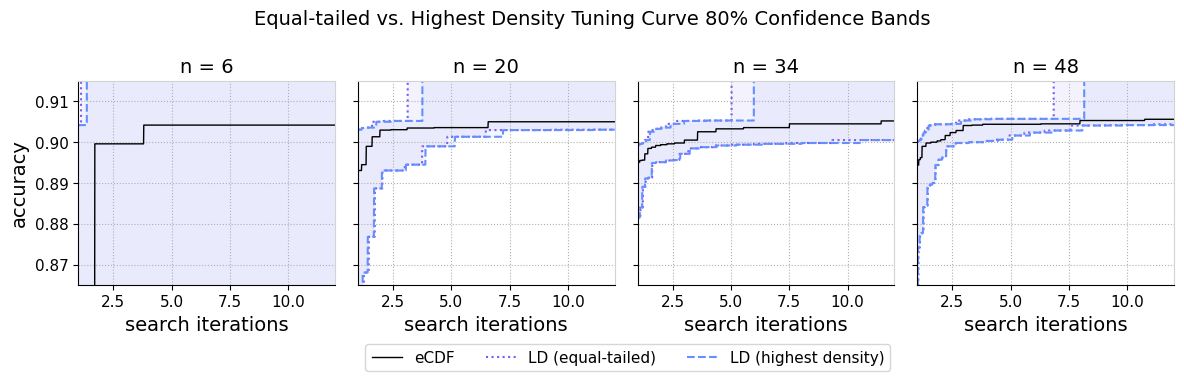

In [27]:
fig, axes = plt.subplots(
    nrows=1, 
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 3.5),
)
for i, sample_size_ in enumerate(sample_sizes):
    ys = np.random.choice(
        model_to_evaluation_to_ys[model][evaluation],
        size=sample_size_,
        replace=False,
    )
    
    axes[i].plot(
        ns_grid,
        nonparametric.EmpiricalDistribution(ys).quantile_tuning_curve(ns_grid),
        linewidth=1,
        linestyle='-',
        color='k',
        label='eCDF',
    )

    for band_ in ['ld_equal_tailed', 'ld_highest_density']:
        lower_cdf, _, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band_,
            )
        
        axes[i].plot(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            label=bands[band_]['name'],
            **bands[band_]['style'],
        )
        axes[i].plot(
            ns_grid,
            lower_cdf.quantile_tuning_curve(ns_grid),
            **bands[band_]['style'],
        )
        axes[i].fill_between(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            lower_cdf.quantile_tuning_curve(ns_grid),
            alpha=0.075,
            **bands[band_]['style'],
        )

# Format the plot.
axes[0].set_ylabel('accuracy')

for i, sample_size_ in enumerate(sample_sizes):
    axes[i].set_xlim(1, n // 4)
    axes[i].set_ylim(0.865, 0.915)
    axes[i].set_xlabel('search iterations')
    axes[i].set_title(f'n = {sample_size_}')
    axes[i].spines['right'].set_color('lightgrey')
    axes[i].spines['top'].set_color('lightgrey')

fig.suptitle(
    f'Equal-tailed vs. Highest Density Tuning Curve {100 * confidence:.0f}% Confidence Bands'
)

fig.tight_layout()

axes[1].legend(
    loc='upper left',
    bbox_to_anchor=(0., -0.25),
    ncol=3,
)

plt.show()

and DeBERTa and DeBERTaV3 are again highly similar:

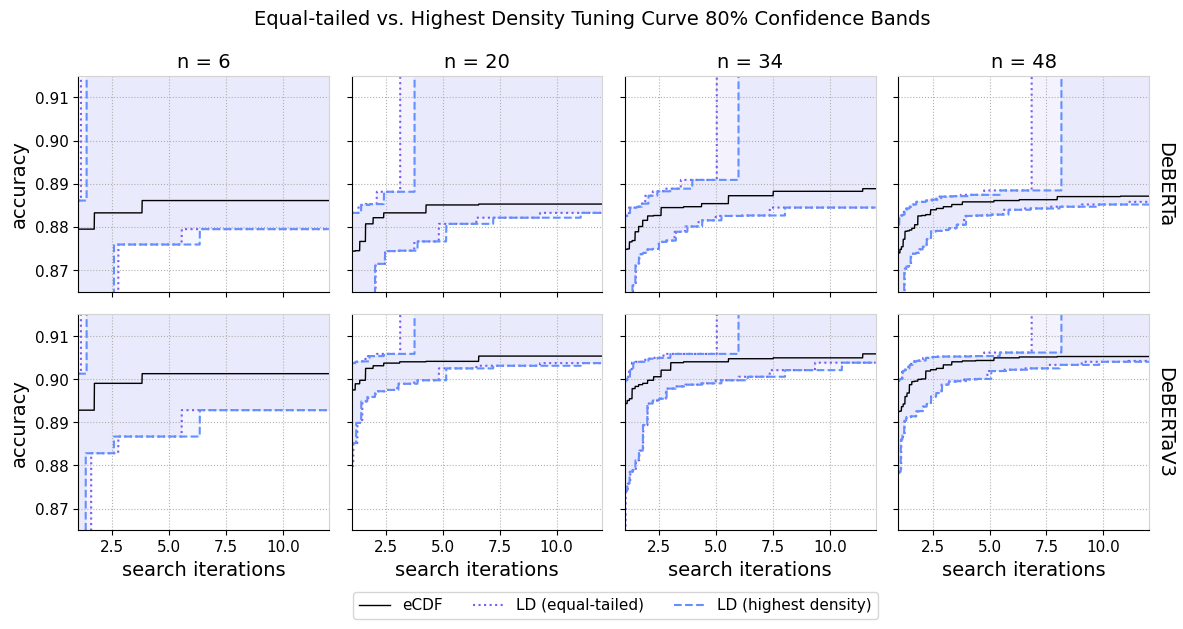

In [28]:
fig, axes = plt.subplots(
    nrows=2, 
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 6),
)
for i, model_ in enumerate(models):
    for j, sample_size_ in enumerate(sample_sizes):
        ys = np.random.choice(
            model_to_evaluation_to_ys[model_][evaluation],
            size=sample_size_,
            replace=False,
        )

        axes[i, j].plot(
            ns_grid,
            nonparametric.EmpiricalDistribution(ys).quantile_tuning_curve(ns_grid),
            linewidth=1,
            linestyle='-',
            color='k',
            label='eCDF',
        )

        for band_ in ['ld_equal_tailed', 'ld_highest_density']:
            lower_cdf, _, upper_cdf =\
                nonparametric.EmpiricalDistribution.confidence_bands(
                    ys,
                    confidence=confidence,
                    a=y_min,
                    b=y_max,
                    method=band_,
                )

            axes[i, j].plot(
                ns_grid,
                upper_cdf.quantile_tuning_curve(ns_grid),
                label=bands[band_]['name'],
                **bands[band_]['style'],
            )
            axes[i, j].plot(
                ns_grid,
                lower_cdf.quantile_tuning_curve(ns_grid),
                **bands[band_]['style'],
            )
            axes[i, j].fill_between(
                ns_grid,
                upper_cdf.quantile_tuning_curve(ns_grid),
                lower_cdf.quantile_tuning_curve(ns_grid),
                alpha=0.075,
                **bands[band_]['style'],
            )

# Format the plot.
for j, sample_size_ in enumerate(sample_sizes):
    axes[1, j].set_xlabel('search iterations')
    axes[0, j].set_title(f'n = {sample_size_}')
    
for i, model_ in enumerate(models):
    axes[i, 0].set_ylabel('accuracy')
    axes[i, -1].yaxis.set_label_position('right')
    axes[i, -1].set_ylabel(models[model_]['name'], labelpad=18, rotation=270)
        
for i in range(len(models)):
    for j in range(len(sample_sizes)):
        axes[i, j].set_xlim(1, n // 4)
        axes[i, j].set_ylim(0.865, 0.915)
        axes[i, j].spines['right'].set_color('lightgrey')
        axes[i, j].spines['top'].set_color('lightgrey')

fig.suptitle(
    f'Equal-tailed vs. Highest Density Tuning Curve {100 * confidence:.0f}% Confidence Bands'
)

fig.tight_layout()

axes[1, 1].legend(
    loc='upper left',
    bbox_to_anchor=(-0.025, -0.25),
    ncol=3,
)

plt.show()

We can use the linear relationship between sample size and where the upper bound becomes trivial to quantify the data efficiency gained by using the highest density instead of the equal-tailed LD bands. Consider the slope for the two different methods:

In [29]:
# Fit lines to the sample size vs. trivial bound iteration relationship.
for band_ in ['ld_equal_tailed', 'ld_highest_density']:
    trivial_bound_iterations = []
    for sample_size_ in sample_sizes:
        ys = np.random.choice(
            model_to_evaluation_to_ys[model][evaluation],
            size=sample_size_,
            replace=False,
        )

        lower_cdf, _, _ =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band_,
            )

        trivial_bound_iterations.append(
            ns_grid[np.argmax(lower_cdf.quantile_tuning_curve(ns_grid))]
        )

    # Fit a linear regression to the sample size/trivial bound iteration data.
    regression = stats.linregress(sample_sizes, trivial_bound_iterations)
    
    print(
        f'{bands[band_]["name"]: <20}: '
        f' y = {regression.slope:.3f}x + {regression.intercept:.3f}'
    )

LD (equal-tailed)   :  y = 0.136x + 0.360
LD (highest density):  y = 0.161x + 0.470


Since the intercepts are about equal, we can approximate the data reduction by the ratio of the slopes, or about 85%. In other words, the highest density bands require about 15% less data to bound the tuning curve up to the same point as the equal-tailed bands at 80% confidence. Note that this relationship *doesn't* depend on the model or technique being tuned, because the width of the bands at each order statistic (and thus at the maximum) are fixed and independent of the data. The shape of the bands only depends on the data through the *location* of the order statistics. Therefore, the highest density bands will always require about 15% less data to achieve a nontrivial bound at the same point as the equal-tailed bands at 80% confidence. Other confidence levels show a similar relationship, though with different levels of data savings.

### Issues with Expected Tuning Curves

While our analysis focuses on *median* tuning curves, the basic approach also constructs conservative confidence bands for *mean* tuning curves. We emphasize the median because it has several advantages over the mean.

As a summary of a distribution, the mean is most interpretable when averaging or summing over a large number of samples, in which case the central limit theorem and law of large numbers apply. Without taking any kind of sum, the mean can be difficult to interpret&mdash;especially if the distribution is skewed. In contrast, the median always has a simple interpretation: the result is equally often above and below it.

The other issue with the mean is that it's difficult to bound in a nonparametric, distribution-free way. Without bounds on the random variable's support, a very small probability can be assigned to an arbitrarily large number. Thus, you'll never observe the number in a sample, but nonetheless the mean can be huge.

Due to this problem and the fact that our confidence bands are distribution-free, they can only bound the mean tuning curve when given proper bounds on the test metric. Even with these bounds, however, the issue causes the mean tuning curve confidence bands to be conservative, rather than exact, and to converge slowly. Comparing the median and mean tuning curve confidence bands, we observe this effect:

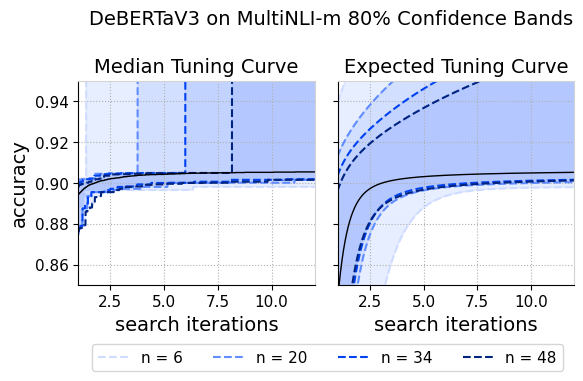

In [30]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(6, 3.5),
)

# Plot the confidence bands for various sample sizes.
ys = np.random.choice(
    model_to_evaluation_to_ys[model][evaluation],
    size=n,
    replace=False,
)
for sample_size_ in sample_sizes:
    # Construct the confidence bands.
    lower_cdf, _, upper_cdf =\
        nonparametric.EmpiricalDistribution.confidence_bands(
            ys[:sample_size_],
            confidence=confidence,
            a=y_min,
            b=y_max,
            method=band,
        )

    # Lighten the band color for the sample size.
    color = visualization.color_with_lightness(
        c=bands[band]['style']['color'],
        lightness=0.75 * (1 - sample_size_ / n) + 0.25,
    )
    
    # Plot the median tuning curve confidence bounds.
    axes[0].plot(
        ns_grid, 
        lower_cdf.quantile_tuning_curve(ns_grid),
        label=f'n = {sample_size_}',
        **{**bands[band]['style'], 'color': color},
    )
    axes[0].plot(
        ns_grid,
        upper_cdf.quantile_tuning_curve(ns_grid),
        **{**bands[band]['style'], 'color': color},
    )
    # The fill color does not need to be modified because it has
    # transparency, so the fills stack on top of each other.
    axes[0].fill_between(
        ns_grid,
        upper_cdf.quantile_tuning_curve(ns_grid),
        lower_cdf.quantile_tuning_curve(ns_grid),
        alpha=0.15,
        color=bands[band]['style']['color'],
    )

    # Plot the average tuning curve confidence bounds.
    axes[1].plot(
        ns_grid, 
        lower_cdf.average_tuning_curve(ns_grid),
        label=f'n = {sample_size_}',
        **{**bands[band]['style'], 'color': color},
    )
    axes[1].plot(
        ns_grid,
        upper_cdf.average_tuning_curve(ns_grid),
        **{**bands[band]['style'], 'color': color},
    )
    # The fill color does not need to be modified because it has
    # transparency, so the fills stack on top of each other.
    axes[1].fill_between(
        ns_grid,
        upper_cdf.average_tuning_curve(ns_grid),
        lower_cdf.average_tuning_curve(ns_grid),
        alpha=0.15,
        color=bands[band]['style']['color'],
    )

# Construct our best estimate of the ground truth CDF.
point_cdf = nonparametric.EmpiricalDistribution(
    model_to_evaluation_to_ys[model][evaluation],
    a=y_min,
    b=y_max,
)
# Plot our best estimate of the ground truth median tuning curve.
axes[0].plot(
    ns_grid, 
    point_cdf.quantile_tuning_curve(ns_grid),
    linewidth=1,
    linestyle='-',
    color='k',
)
# Plot our best estimate of the ground truth average tuning curve.
axes[1].plot(
    ns_grid, 
    point_cdf.average_tuning_curve(ns_grid),
    linewidth=1,
    linestyle='-',
    color='k',
)

# Format the plot.
axes[0].set_ylabel('accuracy')

for i, aggregate in enumerate(['median', 'expected']):
    axes[i].set_xlim(1, n // 4)
    axes[i].set_ylim(0.85, 0.95)
    axes[i].spines['right'].set_color('lightgrey')
    axes[i].spines['top'].set_color('lightgrey')
    axes[i].set_xlabel('search iterations')
    axes[i].set_title(f'{aggregate.capitalize()} Tuning Curve')

fig.suptitle(
    f'{models[model]["name"]} on {evaluations[evaluation]["name"]}'
    f' {confidence * 100:.0f}% Confidence Bands',
    x=0.565,
)

fig.tight_layout()

axes[0].legend(
    loc='upper left',
    bbox_to_anchor=(0.025, -0.25),
    ncol=len(sample_sizes),
)

plt.show()

The median tuning curve confidence bands converge quickly where they provide a nontrivial bound, while the mean tuning curve confidence bands converge slowly across the entire curve. Thus, while the median tuning curve confidence bands enable useful comparisons on the initial part of the curve, the mean tuning curve confidence bands need large sample sizes before yielding useful conclusions.